# Маркетинговый анализ развлекательного приложения Procrastinate Pro+

Фабула. Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

**План исследования**

Шаг 1. Загрузка данные и подготовка их к анализу

Шаг 2. Исследовательский анализ данных

2.1. Создание пользовательских профилей

2.2. Географическое распределение пользователей

2.3. Сегрегация пользователей по устройствам

2.4. Анализ рекламных источников привлечения

Шаг 3. Рассчитайты метрик: продукт, продажи и маркетинг

3.1. Продукт

3.1.1. Рассчеты DAU, WAU и MAU

3.1.2. Исследования пользовательских сессиий

3.2. Продажи

3.2.1. Время до первой покупки

3.2.2. Анализ среднего числа покупок

3.2.3. Рассчитайт среднего чека

3.3. Маркетинг

3.3.1. Расходы на рекламу. Распределение расходов по источникам

3.3.2. Расчеты САС

Шаг 4. Функции для расчёта и визуализации LTV, ROI, удержания и конверсии

Шаг 5. Оценка окупаемости рекламы

5.1. Анализ общей окупаемости рекламы

5.2. Окупаемость рекламы с разбивкой по рекламным каналам

5.3. Окупаемость рекламы с разбивкой по странам

5.4. Конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Шаг 6. Выводы

6.1. Причины неэффективности привлечения пользователей

6.2. Рекомендации для отдела маркетинга

# Шаг 1. Загрузка данных и подготовка их к анализу

In [1]:
# необходимые библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

# настройка отображения графиков
sns.set_style('whitegrid')
sns.set_context('notebook')

In [2]:
# чтение файлов, запись в переменные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'), # визиты
    pd.read_csv('/datasets/orders_info.csv'), # заказы
    pd.read_csv('/datasets/costs_info.csv')   # траты на рекламу
)

# преобразование название колонок
visits = (
    visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device', 
                           'Channel': 'channel', 'Session Start': 'session_start',
                           'Session End': 'session_end'})
)

orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

costs = costs.rename(columns={'Channel': 'channel'})

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')

orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y-%m-%d %H:%M:%S')

costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

# общие данные для анализа
display(visits.head())
display(orders.head())
costs.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Выводы**

На анализ представлены данные развлекательного приложения Procrastinate Pro+ (далее в исследовании - сервис), - выгрузки лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Представленные данные содержат:

- таблица visits (лог сервера с информацией о посещениях сайта):

    - User Id — уникальный идентификатор пользователя;
    - Device — категория устройства пользователя;
    - Session start — дата и время начала сессии;
    - Session End — дата и время окончания сессии;
    - Channel — идентификатор рекламного источника, из которого пришел пользователь;
    - Region - страна пользователя.
    

- таблица orders (информация о заказах):

    - User Id — уникальный id пользователя, который сделал заказ;
    - Event Dt — дата и время покупки;
    - Revenue — выручка.


- таблица costs (информация о затратах на маркетинг):

    - Channel — идентификатор рекламного источника;
    - Dt — дата;
    - Costs — затраты на этот рекламный источник в этот день.
    
Данные прочитаны, записаны в переменные, преобразованы, преведены к нужному типу данных и подготовены для дальнейшего анализа.

In [3]:
# используем методы библиотеки pandas для получения общих сведений о данных, 
# содержащихся в прочитанном и записанном файле,
# проверяем на наличие пропущенных занчений, явных (полных) дубликатов
print('Общие сведения')
print()
visits.info()
print()
print('Пропущенные значения')
display(visits.isna().sum())
print(f'Явных (полных) дубликатов {visits.duplicated().sum()}')

Общие сведения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

Пропущенные значения


user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

Явных (полных) дубликатов 0


Датасет visits (посещения сервиса) содержит 309901 запись (наблюдение) обладающую шестью признаками:
- идентификатор польщзователя - user_id, тип данных - целое число (int64);
- географических признака - region - геолокация совершения входа на сервис, тип данных - object (текстовые или смешанные числовые и нечисловые значения);
- тип устройства, успользуемого пользователем для входы в сервис - device, тип данных - object;
- источник привлечения пользователя - channel, тип данных - object;
- время начала - session_start и время окончания - session_end сессии пользователя, тип данных datetime (данные об опреденном моменте во времени).

Пропущенные значения, явные (полные) дубликаты - отсутвуют.

In [4]:
# используем методы библиотеки pandas для получения общих сведений о данных, 
# содержащихся в прочитанном и записанном файле,
# проверяем на наличие пропущенных занчений, явных (полных) дубликатов
print('Общие сведения')
print()
orders.info()
print()
print('Пропущенные значения')
display(orders.isna().sum())
print(f'Явных (полных) дубликатов {orders.duplicated().sum()}')

Общие сведения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB

Пропущенные значения


user_id     0
event_dt    0
revenue     0
dtype: int64

Явных (полных) дубликатов 0


Датасет orders - данные о совершенных пользователем покупок на сервисе, содержит 40312 записей (наблюдей) о трех признаках активности покупателей сервиса:
- уникальный идентификатор пользователя (присвоенный сервисом при первом посещении, связан с фреймом visits);
- дата и время совершения покупки на сервисе пользователем - event_dt, тип данных datetime;
- стоимость сделки (цена приобретенной услуги сервиса) - revenue, тип данных float (непрерывные величины, числа с плавающей точкой).

Пропущенные значения, явные (полные) дубликаты - отсутвуют.

In [5]:
# используем методы библиотеки pandas для получения общих сведений о данных, 
# содержащихся в прочитанном и записанном файле,
# проверяем на наличие пропущенных занчений, явных (полных) дубликатов
print('Общие сведения')
print()
costs.info()
print()
print('Пропущенные значения')
display(costs.isna().sum())
print(f'Явных (полных) дубликатов {costs.duplicated().sum()}')

Общие сведения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null datetime64[ns]
channel    1800 non-null object
costs      1800 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB

Пропущенные значения


dt         0
channel    0
costs      0
dtype: int64

Явных (полных) дубликатов 0


Датасет costs - рекланые расходы сервиса, содержат 1800 записей отобранных при признакам:
- даты рекламных затрат - dt, тип данных datetime;
- направления рекламных расходов (оплата привлечения пользователей на сервис каналу привлечени) - channel, тип данных object;
- размер расходов - costs, тип данных float.

Пропущенные значения, явные (полные) дубликаты - отсутвуют.

# Шаг 2. Исследовательский анализ данных

Построение профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.

Выяснение следующих вопросов:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [6]:
# находим параметры первых посещений
profiles = (
    visits
    .sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg(
    {
        'session_start': 'first',
        'region': 'first',
        'device': 'first',
        'channel': 'first'
    })
    .rename(columns={'session_start': 'first_ts'})
    .reset_index()
)

# добавляем признак платящих пользователей:
# 1 - пользователь совершил хотя бы одну покупку;
# 0 - пользователь не является плательщиком
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique()) * 1

# приведем к единому стилу наименования рекламного источника
profiles['channel'] = profiles['channel'].replace('organic', 'Organic')

# профили пользователей сервиса
profiles.head(5)

,user_id,first_ts,region,device,channel,payer
0,599326,2019-05-07 20:58:00,United States,Mac,FaceBoom,1
1,4919697,2019-07-09 12:46:00,United States,iPhone,FaceBoom,0
2,6085896,2019-10-01 09:58:00,France,iPhone,Organic,0
3,22593348,2019-08-22 21:35:00,Germany,PC,AdNonSense,0
4,31989216,2019-10-02 00:07:00,United States,iPhone,YRabbit,0


In [7]:
print(f"Самая ранняя дата привлечения пользователей {profiles['first_ts'].dt.date.min()}")
print()
print(f"Самая поздняя дата привлечения пользователей {profiles['first_ts'].dt.date.max()}")

Самая ранняя дата привлечения пользователей 2019-05-01

Самая поздняя дата привлечения пользователей 2019-10-27


Таким образом, условия исследования данных лог сервера о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, соблюдены.


Таким образом, настоящее исследование охватывает период работы сервиса с 01 мая 2019 года по 27 октября 2019 года.

In [8]:
profiles.head()

,user_id,first_ts,region,device,channel,payer
0,599326,2019-05-07 20:58:00,United States,Mac,FaceBoom,1
1,4919697,2019-07-09 12:46:00,United States,iPhone,FaceBoom,0
2,6085896,2019-10-01 09:58:00,France,iPhone,Organic,0
3,22593348,2019-08-22 21:35:00,Germany,PC,AdNonSense,0
4,31989216,2019-10-02 00:07:00,United States,iPhone,YRabbit,0


In [9]:
(
    profiles
    .groupby('region')
    .agg({'user_id': 'nunique', 'payer': 'sum'})
    .assign(conversion = lambda x: x['payer'] / x['user_id'])
)

,user_id,payer,conversion
region,,,
France,17450,663,0.037994
Germany,14981,616,0.041119
UK,17575,700,0.039829
United States,100002,6902,0.069019


,region,number_of_users,number_of_paying_users,share_of_users,share_of_paying_users,conversion
0,United States,100002,6902,0.67,0.78,0.07
1,UK,17575,700,0.12,0.08,0.04
2,France,17450,663,0.12,0.07,0.04
3,Germany,14981,616,0.10,0.07,0.04


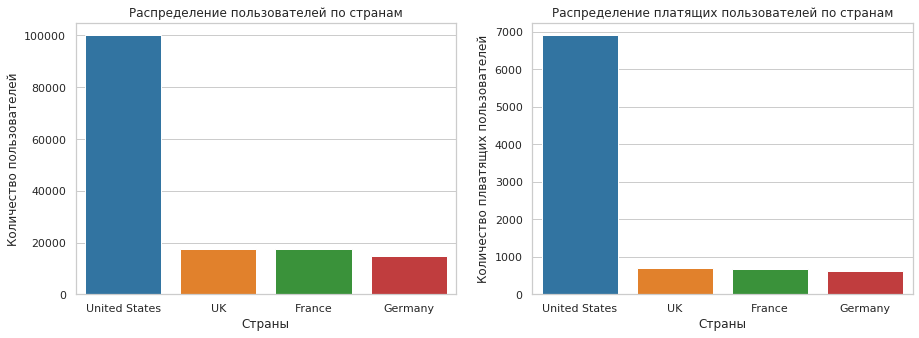

In [10]:
# формируем сводную таблицу по странам
profiles_region = (
    profiles
    .groupby('region')
    .agg({'user_id': 'nunique', 'payer': 'sum'}) # рассчитываем количество пользователей (общее и платящих)
    .assign(
        share_of_users = lambda x: (x['user_id'] / x['user_id'].sum()).round(2),    # определяем долю пользователей
        share_of_paying_users = lambda x: (x['payer'] / x['payer'].sum()).round(2), # определяем долю платящих пользователей
        conversion = lambda x: (x['payer'] / x['user_id']).round(2)                 # определяем конверсию
           )
    .rename(columns={'user_id': 'number_of_users',
                    'payer': 'number_of_paying_users'})
    .sort_values('number_of_users', ascending=False)
    .reset_index()
)

# данные пользователей, детализированные географически
display(profiles_region)

# визуализируем сводную таблицу
plt.figure(figsize=(15, 5))

(
sns.barplot(data=profiles_region, x='region', y='number_of_users', ax=plt.subplot(1, 2, 1))
    .set(xlabel='Страны', ylabel='Количество пользователей')
)
plt.title('Распределение пользователей по странам')

(
    sns.barplot(data=profiles_region, x='region', y='number_of_paying_users', ax=plt.subplot(1, 2, 2))
    .set(xlabel='Страны', ylabel='Количество плватящих пользователей')
)
plt.title('Распределение платящих пользователей по странам')

plt.show()

Итак, наибольшее число пользователь (100002 или 67%) впервые совершили вход в приложении сервиса с территории Соединенных Штатов. Эти же пользователи (6902 или 78%) стали платными клиентами сервиса (совершили хотя бы одну покупку).

Пользователи, совершившие первый вход в приложении сервиса с территорий Соединенного Корелевства, Франции и Германии распределились практически равномерно (17575 или 12%, 17450 или 12% и 14981 или 10% соответсвенно). Эти же пользователи (700 или 12%, 663 или 12% и 616 или 10% соответсвенно) стали плательщиками. 

Таким, лучшую конверсию продемонстрировали пользователи США на уровне 7%, конверсия пользователей Соединенного Королевства, Франции и Германии одинакова, на уровне 4%.

,device,number_of_users,number_of_paying_users,share_of_users,share_of_paying_users,conversion
0,iPhone,54479,3382,0.36,0.38,0.06
1,Android,35032,2050,0.23,0.23,0.06
2,PC,30455,1537,0.20,0.17,0.05
3,Mac,30042,1912,0.20,0.22,0.06


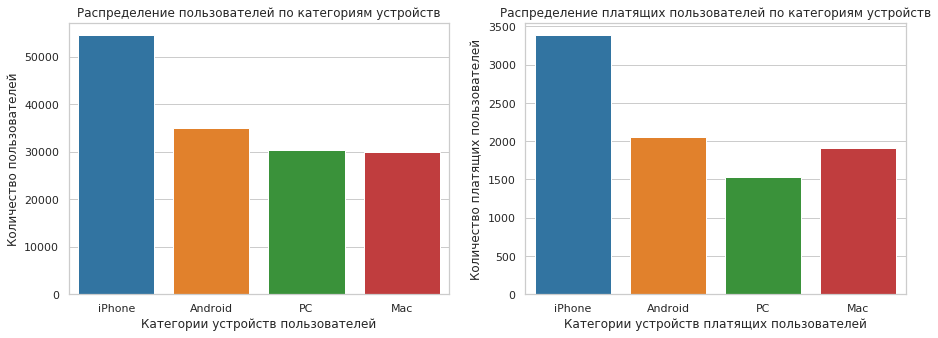

In [11]:
# формируем сводную таблицу по категориям устройств 
profiles_device = (
    profiles
    .groupby('device')
    .agg({'user_id': 'nunique', 'payer': 'sum'}) # рассчитываем количество пользователей (общее и платящих)
    .assign(
        share_of_users = lambda x: (x['user_id'] / x['user_id'].sum()).round(2),    # определяем долю пользователй
        share_of_paying_users = lambda x: (x['payer'] / x['payer'].sum()).round(2), # определяем долю платящих пользователей
        conversion = lambda x: (x['payer'] / x['user_id']).round(2)                 # определяем конверсию
           )
    .rename(columns={'user_id': 'number_of_users',
                    'payer': 'number_of_paying_users'})
    .sort_values('number_of_users', ascending=False)
    .reset_index()
)

# данные пользователей, персонофицированные по устройствам
display(profiles_device)

# визуализируем сводную таблицу
plt.figure(figsize=(15, 5))

(
    sns.barplot(data=profiles_device, x='device', y='number_of_users', ax=plt.subplot(1, 2, 1))
    .set(xlabel='Категории устройств пользователей', ylabel='Количество пользователей')
)
plt.title('Распределение пользователей по категориям устройств')

(
    sns.barplot(data=profiles_device, x='device', y='number_of_paying_users', ax=plt.subplot(1, 2, 2))
    .set(xlabel='Категории устройств платящих пользователей', ylabel='Количество платящих пользователей')
)
plt.title('Распределение платящих пользователей по категориям устройств')

plt.show()

Итак, большинство пользователей совершили первую сессию с мобильных устройств (59% от всех первых визитов), при этом 54479 или 36% воспользователи iPhone, 35032 или 23% - устройствами на ОС Android. Эти же пользователи стали лидерами в покупках: совершили хотя бы одну покупку 3382 или 38% владельцев iPhone и 2050 или 23% владельцы мобильных устройств на ОС Android.

Первые посещения сервиса с десктопов распределились практически равномерно среди пользователей Mac и прочих РС: 30042 или 20% и 30455 или 20% соответсвенно. Однако, больше пользователей Mac совершили хотя бы одну покупку 1912 или 22% против 1537 или 17% пользователей прочих PC.

Таким образом, конверсия пользователей iPhone, Android и Мас одинаковая и равна 6%, конверсия пользователей РС немного отстает и находиться на уровне 5%.

,channel,number_of_users,number_of_paying_users,share_of_users,share_of_paying_users,conversion
0,Organic,56439,1160,0.38,0.13,0.02
1,FaceBoom,29144,3557,0.19,0.40,0.12
2,TipTop,19561,1878,0.13,0.21,0.10
3,OppleCreativeMedia,8605,233,0.06,0.03,0.03
4,LeapBob,8553,262,0.06,0.03,0.03
5,WahooNetBanner,8553,453,0.06,0.05,0.05
6,RocketSuperAds,4448,352,0.03,0.04,0.08
7,MediaTornado,4364,156,0.03,0.02,0.04
8,YRabbit,4312,165,0.03,0.02,0.04
9,AdNonSense,3880,440,0.03,0.05,0.11


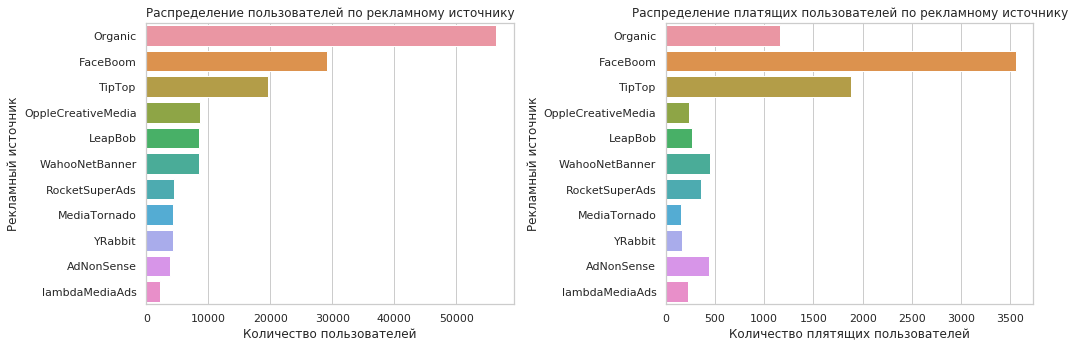

In [12]:
# формируем сводную таблицу по идентификатору рекламного источника, из которого пришел пользователь
profiles_channel = (
    profiles
    .groupby('channel')
    .agg({'user_id': 'nunique', 'payer': 'sum'}) # рассчитываем количество пользователей (общее и платящих)
    .assign(
        share_of_users = lambda x: (x['user_id'] / x['user_id'].sum()).round(2),    # определяем долю пользователй
        share_of_paying_users = lambda x: (x['payer'] / x['payer'].sum()).round(2), # определяем долю платящих пользователей
        conversion = lambda x: (x['payer'] / x['user_id']).round(2)                 # определяем конверсию
           )
    .rename(columns={'user_id': 'number_of_users',
                    'payer': 'number_of_paying_users'})
    .sort_values('number_of_users', ascending=False)
    .reset_index()
)

# данные пользователей по канал привлечения
display(profiles_channel)

# визуализируем сводную таблицу
plt.figure(figsize=(15, 5))

(
    sns.barplot(data=profiles_channel, y='channel', x='number_of_users', ax=plt.subplot(1, 2, 1))
    .set(xlabel='Количество пользователей', ylabel='Рекламный источник')
)
plt.title('Распределение пользователей по рекламному источнику')

(
    sns.barplot(data=profiles_channel, y='channel', x='number_of_paying_users', ax=plt.subplot(1, 2, 2))
    .set(xlabel='Количество плятящих пользователей', ylabel='Рекламный источник')
)
plt.title('Распределение платящих пользователей по рекламному источнику')

plt.tight_layout()

plt.show()

Таким образом, основные пользователи (56439 или 38%) перешли на сервис вне рекламных каналов, 1160 или 13% стали покупателями (совершили, как минимум одну покупку на сервисе).

Среди платных источников, привлекших пользователей на сервис, выдяются FaceBoom (29144 или 19%) и TipTop (19561 или 13%). Кроме того, FaceBoom и TipTop стали главными поставщиком платящих пользоватлей (3557 или 40% и 1878 или 13% соответсвенно).

Аутсайдерами среди рекланых источников по числу привлекших на сервис пользоателей стали (по 3%): RocketSuperAds(4448),  MediaTornado (4364), YRabbit(4312) и AdNonSense(3880). На последней строчке (менее 1%) расположился lambdaMediaAds(2149).

Меньше всего платящих пользователей привлекли (по 2%): MediaTornado(156) и YRabbit(165).

В то же время, лучшую конверсию продемонстрировали пользователи FaceBoom (12%), AdNonSense(11%), lambdaMediaAds(10%) и RocketSuperAds(8%). Пользователи, пришедшие на сервис вне рекламных каналов, в меньшей доли стали платящими - 2%.

**Выводы**

По имеющимся данным из фремов visits и orders свормированы профили клиентов, записаны в переменную profiles, содержащие информацию первого посещения сервиса со следующими признаками:

- user_id - уникальный идентификатор клиента;
- first_ts - дата и время первого посещения сервиса;
- region - территория, с которой был осуществлен вход на сервис первый раз;
- divice - тип устройства;
- channel - рекламный канал, который привлек пользователя;
- payer - колонка-флаг: совершил ли пользователь хотя бы одну покупку за анализируемый период (отметка 1); пользователь не является плательщиком (отметка 0).

Установлен и подтвержден временной интервал имеющихся в распоряженные данных - с 01 мая 2019 года по 27 октября 2019 года. Исследования охватывает обозначенный временной горизонт.

В ходе исследовательского анализа данных разрешены следующие вопросы:

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Так, наибольшее число пользователь (100002 или 67%) впервые совершили вход в приложении сервиса с территории Соединенных Штатов. Эти же пользователи (6902 или 78%) стали платными клиентами сервиса (совершили хотя бы одну покупку).

Пользователи, совершившие первый вход в приложении сервиса с территорий Соединенного Корелевства, Франции и Германии распределились практически равномерно (17575 или 12%, 17450 или 12% и 14981 или 10% соответсвенно). Эти же пользователи (700 или 12%, 663 или 12% и 616 или 10% соответсвенно) стали плательщиками.

Лучшую конверсию продемонстрировали пользователи США на уровне 7%, конверсия пользователей Соединенного Королевства, Франции и Германии одинакова, на уровне 4%.

Большинство пользователей совершили первую сессию с мобильных устройств (59% от всех первых визитов), при этом 54479 или 36% воспользователи iPhone, 35032 или 23% - устройствами на ОС Android. Эти же пользователи стали лидерами в покупках: совершили хотя бы одну покупку 3382 или 38% владельцев iPhone и 2050 или 23% владельцы мобильных устройств на ОС Android.

Первые посещения сервиса с десктопов распределились практически равномерно среди пользователей Mac и прочих РС: 30042 или 20% и 30455 или 20% соответсвенно. Однако, больше пользователей Mac совершили хотя бы одну покупку 1912 или 22% против 1537 или 17% пользователей прочих PC.

Конверсия пользователей iPhone, Android и Мас одинаковая и равна 6%, конверсия пользователей РС немного отстает и находиться на уровне 5%.

Основные пользователи (56439 или 38%) перешли на сервис вне рекламных каналов, 1160 или 13% стали покупателями (совершили, как минимум одну покупку на сервисе).

Среди платных источников, привлекших пользователей на сервис, выдяются FaceBoom (29144 или 19%) и TipTop (19561 или 13%). Кроме того, FaceBoom и TipTop стали главными поставщиком платящих пользоватлей (3557 или 40% и 1878 или 13% соответсвенно).

Аутсайдерами среди рекланых источников по числу привлекших на сервис пользоателей стали (по 3%): RocketSuperAds(4448),  MediaTornado (4364), YRabbit(4312) и AdNonSense(3880). На последней строчке (менее 1%) расположился lambdaMediaAds(2149).

Меньше всего платящих пользователей привлекли (по 2%): MediaTornado(156) и YRabbit(165).

Лучшую конверсию продемонстрировали пользователи FaceBoom (12%), AdNonSense(11%), lambdaMediaAds(10%) и RocketSuperAds(8%). Пользователи, пришедшие на сервис вне рекламных каналов, в меньшей доли стали платящими - 2%.

Выводы подкреплены аналитическими таблицами и визуализированы.

# Шаг 3. Построение отчётов и расчет метрик
Продукт:

-    Сколько людей пользуются в день, неделю, месяц?
-    Сколько сессий в день?
-    Сколько длится одна сессия?

Продажи:

- Когда люди начинают покупать?
- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?
- Какой средний чек за месяц, неделю, день?

Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### Продукт:
-    Сколько людей пользуются в день, неделю, месяц?

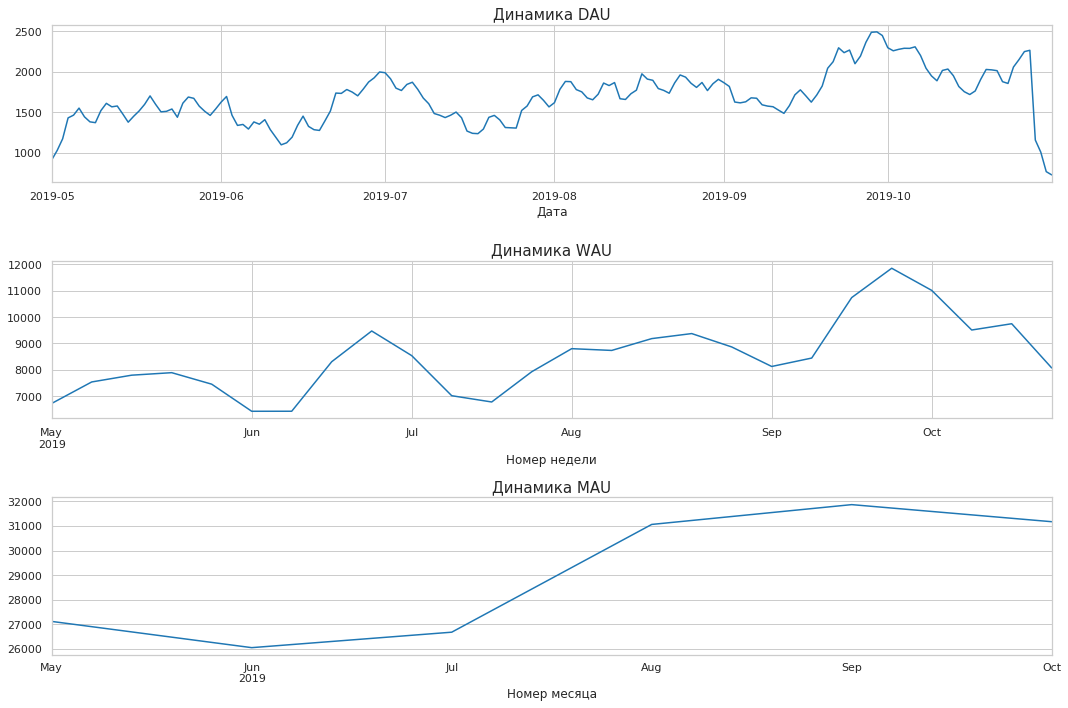

Таким образом, в среднем 1684 людей пользуються сервисов в день, 8490, - в неделю, 28989, - в месяц.


In [13]:
# выделяем год, номер месяца, номер недели и день из времени начала сессии
visits['session_year'] = visits['session_start'].astype('datetime64[Y]')
visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_week'] = visits['session_start'].astype('datetime64[W]')
visits['session_date'] = visits['session_start'].dt.date

# рассчитываем DAU, WAU и MAU
dau = visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau = (
    visits
    .groupby('session_week', as_index=False)
    .agg({'user_id': 'nunique', 'session_date': 'nunique'})
    .query('session_date == 7') # используем в расчетах WAU только польные недели
    ['user_id'].mean()
      )
mau = visits.groupby('session_month').agg({'user_id': 'nunique'}).mean()

# визуализируем данные
plt.figure(figsize=(15, 10))

ax1=plt.subplot(3, 1, 1)
visits.groupby('session_date').agg({'user_id': 'nunique'}).plot(grid=True, ax=ax1, legend=False)
plt.title('Динамика DAU', fontsize=15)
ax1.set_xlabel('Дата')

ax2=plt.subplot(3, 1, 2)
(
    visits.groupby('session_week').agg({'user_id': 'nunique', 'session_date': 'nunique'})
    .query('session_date == 7').drop(columns='session_date')
    .plot(grid=True, ax=ax2, legend=False)
)
plt.title('Динамика WAU', fontsize=15)
ax2.set_xlabel('Номер недели')

ax3=plt.subplot(3, 1, 3)
visits.groupby('session_month').agg({'user_id': 'nunique'}).plot(grid=True, ax=ax3, legend=False)
plt.title('Динамика MAU', fontsize=15)
ax3.set_xlabel('Номер месяца')

plt.tight_layout()

plt.show()

# вывод по результатам расчетов
print(f'Таким образом, в среднем {int(dau)} людей пользуються сервисов в день, {int(wau)}, - в неделю, {int(mau)}, - в месяц.')


-    Сколько сессий в день?

,session_date,number_of_session_per_day
151,2019-09-29,2493
150,2019-09-28,2488
152,2019-09-30,2448
149,2019-09-27,2364
158,2019-10-06,2308


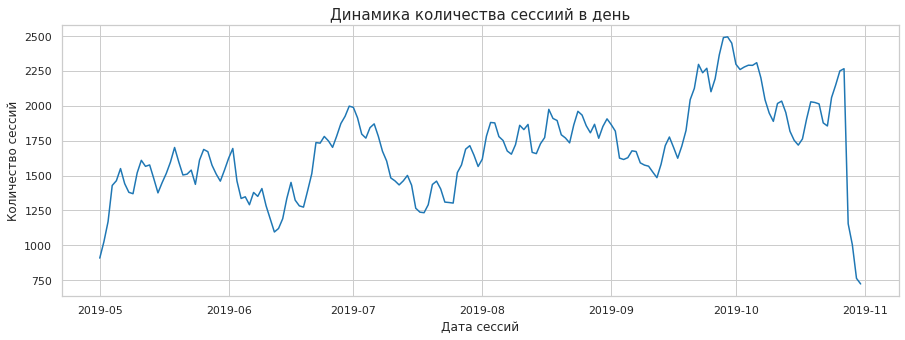

In [14]:
# рассчитываем количество сессий в день
number_of_session_per_day = (
    visits
    .groupby('session_date')['user_id'].count()
    .reset_index()
    .rename(columns={'user_id': 'number_of_session_per_day'})
)

# топ-5 дней по количеству сессий
display(number_of_session_per_day.sort_values(by='number_of_session_per_day', ascending=False).head())

# визуализируем результат
plt.figure(figsize=(15, 5))

(
    sns.lineplot(data=number_of_session_per_day, x='session_date', y='number_of_session_per_day')
    .set(xlabel='Дата сессий', ylabel='Количество сессий')
)

plt.title('Динамика количества сессиий в день', fontsize=15)

plt.show()

01 мая 2019 года были привлечены первые пользователи за анализируемый период, с этого момента начинаеться рост количества сессий в день.

27 октября 2019 года последний день привлечения новых пользователей за анализируемый период, их активность к началу ноября падает, а новых пользоватлей в данных нет, в связи с чем количество сессий резко снижаеться.

В целом, заметен тренд на увеличение количества сессий в день с пиком в 2493 посещения 29 сентября 2019 года.


,number_of_session
count,309900.000000
mean,1.000003
std,0.001796
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,2.000000


,,number_of_session
session_date,user_id,
2019-09-25,572217748747,2


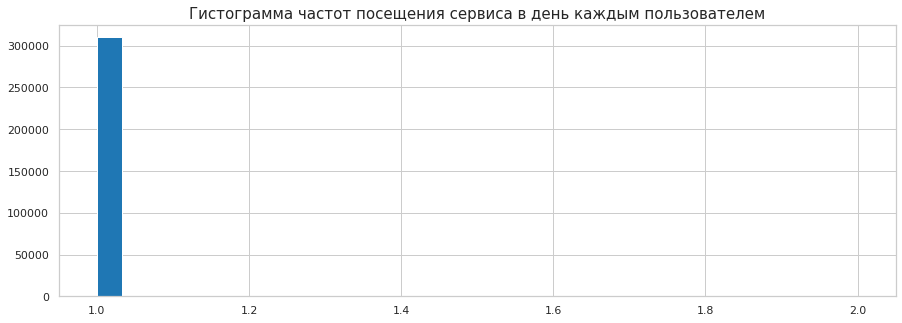

In [15]:
# рассчитываем количество сессий в день на каждого пользователя сервиса
user_number_of_session_per_day = (
    visits
    .groupby(['session_date', 'user_id'])
    .agg({'session_start': 'count'})
    .rename(columns={'session_start': 'number_of_session'})
)

# описательные статистики количестсва сессий в день на каждого пользователя сервиса
display(user_number_of_session_per_day['number_of_session'].describe().to_frame()) # описательные статистики

# пользователи, наиболее часто посещающие сервис в день
display(user_number_of_session_per_day
        [user_number_of_session_per_day['number_of_session'] == user_number_of_session_per_day['number_of_session'].max()])

# визуализируем расчеты
user_number_of_session_per_day['number_of_session'].hist(bins=30, figsize=(15, 5))
plt.title('Гистограмма частот посещения сервиса в день каждым пользователем', fontsize=15)
plt.show()

Таким образом, за анализируемый период, 309900 раз уникальные пользователели в день посещали сервис. При этом средняя и медианная частота посещения каждым пользователем в день сервиса схожа и равна единице при малозначном стандартом отклонении.

Максимальная частота посещения сериса пользователем в день равна двум сессиям, такое событие за анализируемый период имело место один раз - 25 сентября 2019 года, пользователь 572217748747 (при этом, возможно, одна из сессий была закончена с технической ошибкой, была аномально короткой, - вернемся к этому пользователю, при анализе продолжительности одной сессии).

-    Сколько длится одна сессия?

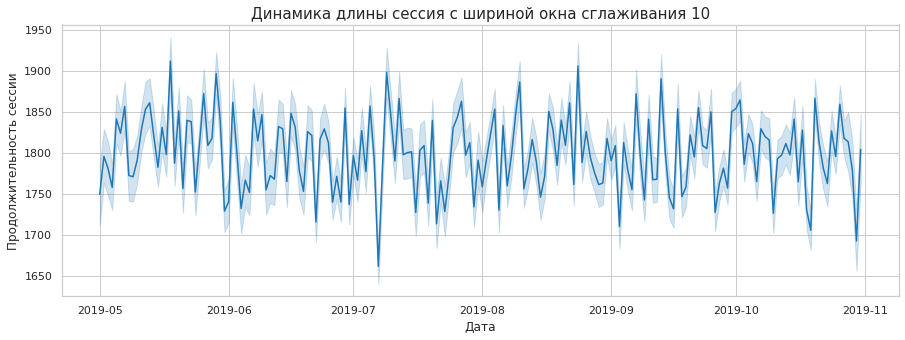

Таким образом, 
1. Средняя продолжительность сессии составила 1800 сек.; 
2. Медианная продолжительность сессии составила 1260 сек.; 
3. Максимальная продолжительность сессии составила 22260.0 сек. и была зафиксирована 2019-05-24;
4. Минимальная продолжительность сессии составила 0.0 сек. и была зафиксирована 2019-05-01;
5. Количество сессиий превышающие медианную продолжительность сессии составляет 150962 
   из общего числа сессий в 309901 или 48.71%.


In [16]:
# рассчитываем длину сессии
visits['session_length'] = (visits['session_end'] - visits['session_start']).dt.total_seconds()

# визуализируем результат
plt.figure(figsize=(15, 5))

visits['session_moving_average'] = visits['session_length'].rolling(10).mean() # рассчитываем скользящие среднее 
                                                                               # с шириной окна 10
(
    sns.lineplot(data=visits, x='session_date', y='session_moving_average')
    .set(xlabel='Дата', ylabel='Продолжительность сессии')
)
plt.title('Динамика длины сессия с шириной окна сглаживания 10', fontsize=15)

plt.show()

# вывод по результатам расчетов
print(f'''Таким образом, 
1. Средняя продолжительность сессии составила {int(visits['session_length'].mean())} сек.; 
2. Медианная продолжительность сессии составила {int(visits['session_length'].median())} сек.; 
3. Максимальная продолжительность сессии составила {visits['session_length'].max()} сек. и была зафиксирована {visits.loc[visits['session_length'].max(), 'session_date']};
4. Минимальная продолжительность сессии составила {visits['session_length'].min()} сек. и была зафиксирована {visits.loc[visits['session_length'].min(), 'session_date']};
5. Количество сессиий превышающие медианную продолжительность сессии составляет {visits.loc[visits['session_length'] > 1260, 'session_length'].count()} 
   из общего числа сессий в {visits['session_length'].count()} или {(visits.loc[visits['session_length'] > 1260, 'session_length'].count() / visits['session_length'].count() * 100).round(2)}%.''')

Рассмотрим пользователя 572217748747, который 25 сентября 2019 года дважды начинал сессии на сервисе. Обладая знания о средней и медианной продолжительности пребывания на серивисе пользователей, оценим продолжительность сессий пользователя 572217748747.

,session_date,session_length
156254,2019-09-23,4140.0
157398,2019-09-25,120.0
158784,2019-09-25,1800.0
164723,2019-09-29,1740.0
171015,2019-10-03,1020.0
174066,2019-10-05,180.0
177179,2019-10-07,900.0
188954,2019-10-16,300.0
192636,2019-10-19,780.0
196725,2019-10-22,1200.0


,session_length
count,10.000000
mean,1218.000000
std,1183.570868
min,120.000000
25%,420.000000
50%,960.000000
75%,1605.000000
max,4140.000000


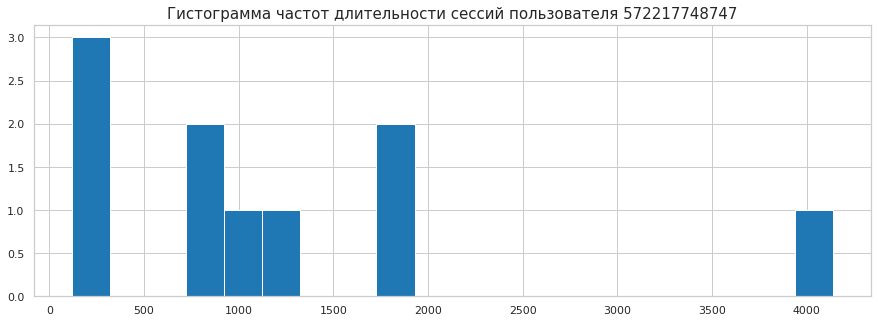

Количество пользователь сервиса с продолжительностью сессии меньше или равно 120 сек. составляет 15175


In [17]:
# поведение пользователя 572217748747 на сервисе по длительности сессий
user_572217748747 = visits[visits['user_id'] == 572217748747][['session_date', 'session_length']]
display(user_572217748747)

# описательные статистки длительности сессий пользователя 572217748747
display(user_572217748747['session_length'].describe().to_frame())

# визуализируем расчеты
user_572217748747['session_length'].hist(bins=20, figsize=(15, 5))
plt.title('Гистограмма частот длительности сессий пользователя 572217748747', fontsize=15)
plt.show()

print(f"Количество пользователь сервиса с продолжительностью сессии меньше или равно 120 сек. составляет {visits[visits['session_length'] <= 120]['user_id'].count()}")

Таким образом, всего пользователь 572217748747 за анализируемый период совершил 10 сессий на сервисе. 25 сентября 2019 года длительность первой сессии составила 120 сек., при средней на сервисе 1800 сек. и медианной 1260 сек.

При этом польщователь 572217748747 три раза из десяти пользовался сервис менее 500 сек., при личной средней продолжительности сессии в 1218 сек. и медианной в 960 сек.

Отметим, что в целом по сервису порядка 15175 пользователя совершали сессии продолжитльеностью меньше или равной 120 сек.

Таким образом, сессию пользователя 572217748747 от 25 сентября 2019 следует признать состоявшейся.

,summary
count,309901.000000
mean,1800.084801
std,1803.189827
min,0.000000
25%,540.000000
50%,1260.000000
75%,2520.000000
max,22260.000000


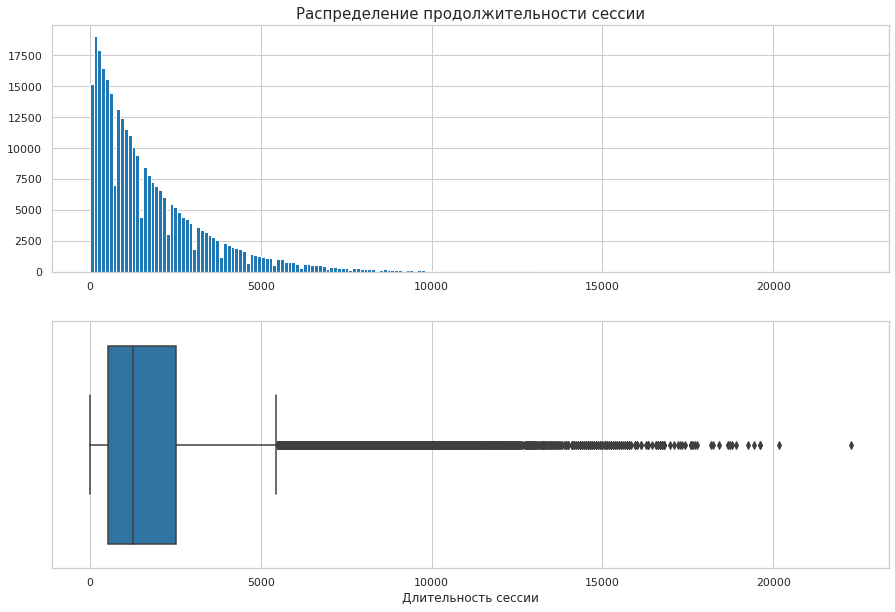

In [18]:
# описательные статистики продолжительности сессии
display(visits['session_length'].describe().to_frame().rename(columns={'session_length': 'summary'}))

# визуализируем распределение продолжительности сессии
plt.figure(figsize=(15, 10))

visits['session_length'].hist(bins=200, ax=plt.subplot(2, 1, 1))
plt.title('Распределение продолжительности сессии', fontsize=15)
plt.xlabel=False

sns.boxplot(visits['session_length'], ax=plt.subplot(2, 1, 2)).set(xlabel='Длительность сессии')

plt.show()

Таким образом, часть сессий (порядка 15000) имеют продолжительность близкую к 0 сек., что представляеться возможным трактовать, как ошибочные входы пользователей на сервис, так и наличием технических ошибок (сессии заканчиваються принудительно).

Таким образом, сессии превышающие 6750 сек. (1,5 межквартильного размаха) после консультации с продакт-менеджером об особенность сервиса, возможно, признать аномально длительными (либо пользователь не завершил сессию, либо техническая ошибка).

In [19]:
# комментарий ревьюера:
tmp = (visits
       .query('session_length == 0')
       .groupby(['region','device'])
       .agg(users_with_zero_duration = ('user_id','nunique'))
       .reset_index()
       .merge((visits
       .groupby(['region','device'])
       .agg(total_users = ('user_id','nunique'))
       .reset_index()), on = ['region','device'], how = 'left')
      )
tmp['share_of_users_with_zero_sessions'] = tmp['users_with_zero_duration'] / tmp['total_users'] 
tmp

,region,device,users_with_zero_duration,total_users,share_of_users_with_zero_sessions
0,France,Android,154,5397,0.028534
1,France,Mac,64,1979,0.032340
2,France,PC,228,7101,0.032108
3,France,iPhone,128,3565,0.035905
4,Germany,Android,133,4568,0.029116
5,Germany,Mac,49,1697,0.028874
6,Germany,PC,191,6080,0.031414
7,Germany,iPhone,103,3130,0.032907
8,UK,Android,174,5327,0.032664
9,UK,Mac,54,1917,0.028169


,channel,users_with_zero_duration,total_users,share_of_users_with_zero_sessions
9,lambdaMediaAds,111,2410,0.046058
6,TipTop,869,20204,0.043011
5,RocketSuperAds,191,4988,0.038292
7,WahooNetBanner,304,8845,0.034370
10,organic,1762,57673,0.030552
0,AdNonSense,128,4199,0.030483
8,YRabbit,146,4882,0.029906
2,LeapBob,258,8875,0.029070
4,OppleCreativeMedia,258,8929,0.028895
3,MediaTornado,141,4895,0.028805


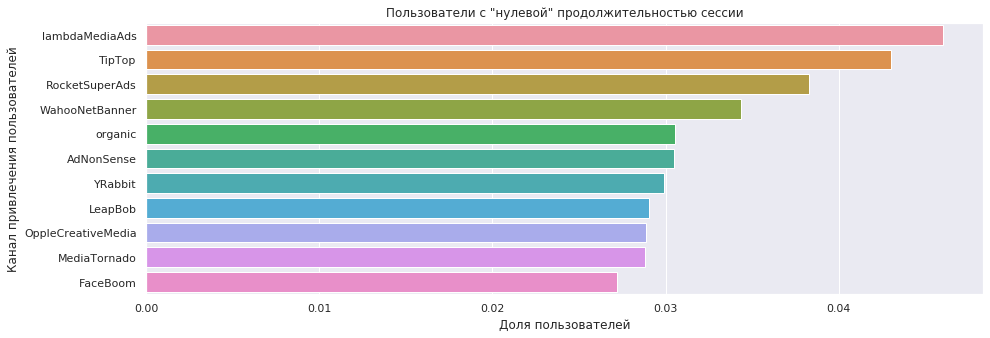

In [20]:
# рассчитываем долю пользователей сервиса с нулевой продолжительностью сессии в разрезе каналов привлечения
users_with_zero_duration_by_channel = (
    visits
    .query('session_length == 0')
    .groupby('channel')
    .agg(users_with_zero_duration = ('user_id','nunique'))
    .reset_index()
    .merge(
        (
            visits
            .groupby('channel')
            .agg(total_users = ('user_id','nunique')
                )
            .reset_index()), 
        on ='channel', how ='left')
      )
users_with_zero_duration_by_channel['share_of_users_with_zero_sessions'] = (
    users_with_zero_duration_by_channel['users_with_zero_duration'] / users_with_zero_duration_by_channel['total_users']
) 

# отображаем результаты расчетов
display(users_with_zero_duration_by_channel.sort_values(by='share_of_users_with_zero_sessions', ascending=False))

# визуализируем расчеты
sns.set(rc={'figure.figsize':(15, 5)})
(
    sns.barplot(data=users_with_zero_duration_by_channel
                .sort_values(by='share_of_users_with_zero_sessions', ascending=False), 
                x='share_of_users_with_zero_sessions', 
                y='channel')
    .set(xlabel='Доля пользователей', 
         ylabel='Канал привлечения пользователей', 
         title='Пользователи с "нулевой" продолжительностью сессии')
);

Таким образом, доля пользователей с нулевой сессий примерно равная, как по регионам и устройстам пользоателей, так и по каналам привлечения.

### Продажи:

- Когда люди начинают покупать?

,summary
count,8881.000000
mean,1.702511
std,5.944318
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,132.000000


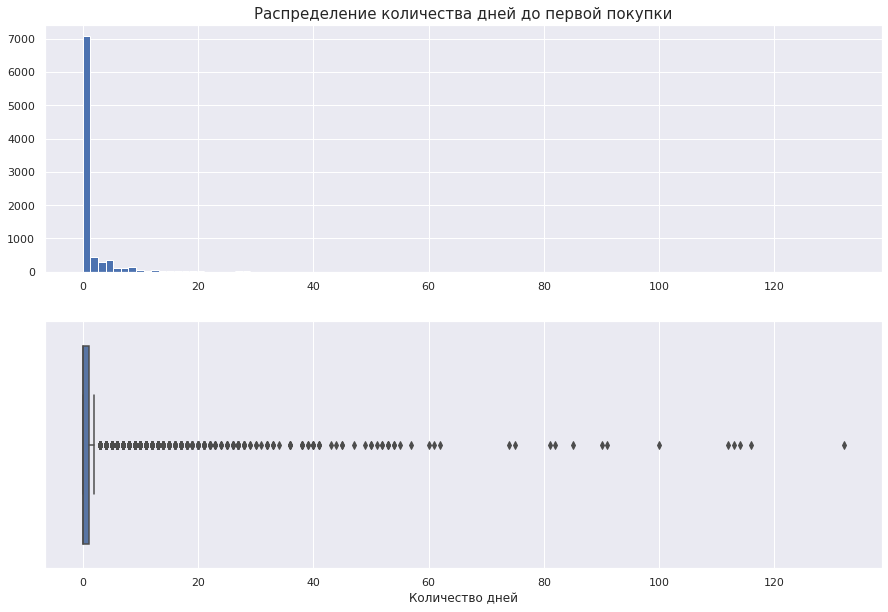

Таким образом, в первый день совершают покупку 6194 из 8881 всех платных пользователей сервиса, что составляет 69.74%.


In [21]:
# создаем фрейм с уникальным идентификатором покупателя, датой регистрации на сервисе и датой первой покупки
profiles_purchase = (
    profiles.query('payer == 1')                            # выбираем пользователей совершивших покупку
    .merge(                                                 # объединяем с данными о покупках пользователей
        (
            orders.sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({'event_dt': 'first', 'revenue': 'first'}) # определяем дату совершения первой покупки                    
            .rename(columns={'event_dt': 'first_event_ts'})
            .reset_index()
        ), on='user_id', how='left')
    .assign(time_to_first_purchase = lambda x: 
            (x['first_event_ts'] - x['first_ts']).dt.days)  # рассчитывем время до первой покупки
)

# описательные статистики количества дней до первой покупки после регистрации на сервисе
display(profiles_purchase['time_to_first_purchase'].describe().to_frame().rename(columns={'time_to_first_purchase': 'summary'}))

# визуализируем распределение
plt.figure(figsize=(15, 10))

profiles_purchase['time_to_first_purchase'].hist(bins=100, ax=plt.subplot(2, 1, 1))
plt.title('Распределение количества дней до первой покупки', fontsize=15)
plt.xlabel=False

sns.boxplot(profiles_purchase['time_to_first_purchase'], ax=plt.subplot(2, 1, 2)).set(xlabel='Количество дней')

plt.show()

print(f'''Таким образом, в первый день совершают покупку {profiles_purchase[profiles_purchase['time_to_first_purchase'] == 0]['time_to_first_purchase'].count()} из {profiles_purchase['time_to_first_purchase'].count()} всех платных пользователей сервиса, что составляет {(profiles_purchase[profiles_purchase['time_to_first_purchase'] == 0]['time_to_first_purchase'].count() / profiles_purchase['time_to_first_purchase'].count() * 100).round(2)}%.''')

В среднем пользователю требуется 2 дня для принятие решения о покупки, при этом половина пользователей совершают покупку в день регистрации на сервисе, а максимальное время принятия решения о покупке за анализируемый период составляет 132 дня.

- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

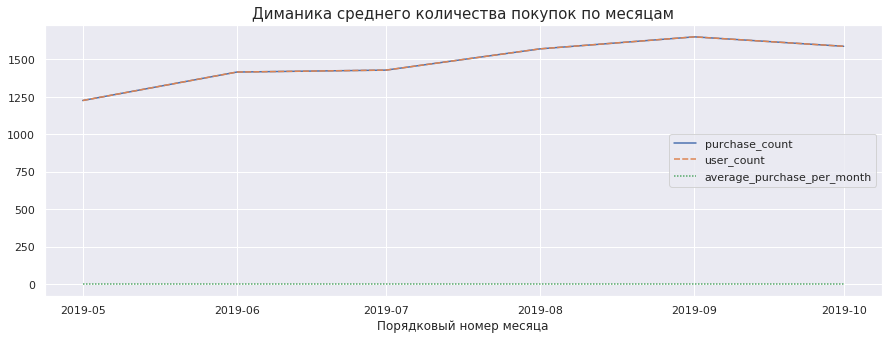

Среднее число покупок платящего пользователя в месяц составляет 1.0.


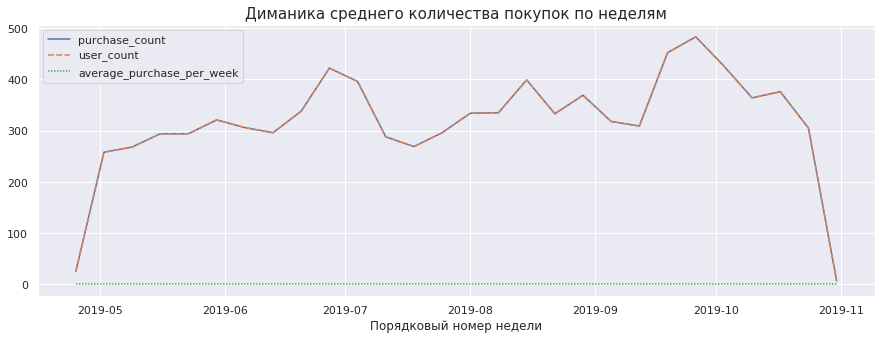

Среднее число покупок платящего пользователя в неделю составляет 1.0.


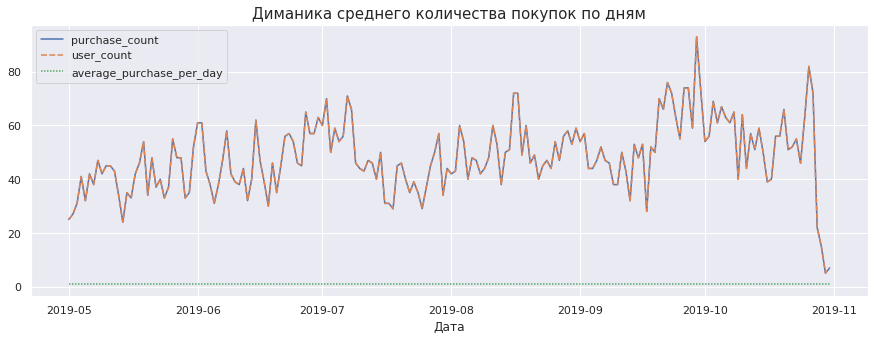

Среднее число покупок платящего пользователя в день составляет 1.0.


In [22]:
# выделяем месяц, неделю, день из даты совершения покупки платящими пользователями
profiles_purchase['event_month'] = profiles_purchase['first_event_ts'].astype('datetime64[M]')
profiles_purchase['event_week'] = profiles_purchase['first_event_ts'].astype('datetime64[W]')
profiles_purchase['event_day'] = profiles_purchase['first_event_ts'].dt.date

# рассчитываем среднее число покупок платящего пользователя по месяцам
average_purchase_per_month = (
    profiles_purchase.groupby('event_month')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
    .assign(average_purchase_per_month = lambda x: x['revenue'] / x['user_id'])
    .rename(columns={'revenue': 'purchase_count', 'user_id': 'user_count'})
)

# визуализируем расчеты по месяцам
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_purchase_per_month).set(xlabel='Порядковый номер месяца')
plt.title('Диманика среднего количества покупок по месяцам', fontsize=15)
plt.show()

# вывод по месяцу
print(f"Среднее число покупок платящего пользователя в месяц составляет {average_purchase_per_month['average_purchase_per_month'].mean().round(2)}.")

# рассчитываем среднее число покупок платящего пользователя по неделям
average_purchase_per_week = (
    profiles_purchase.groupby('event_week')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
    .assign(average_purchase_per_week = lambda x: x['revenue'] / x['user_id'])
    .rename(columns={'revenue': 'purchase_count', 'user_id': 'user_count'})
)

# визуализируем расчеты по неделям
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_purchase_per_week).set(xlabel='Порядковый номер недели')
plt.title('Диманика среднего количества покупок по неделям', fontsize=15)
plt.show()

# вывод по неделе
print(f"Среднее число покупок платящего пользователя в неделю составляет {average_purchase_per_week['average_purchase_per_week'].mean().round(2)}.")


# рассчитываем среднее число покупок платящего пользователя в день
average_purchase_per_day = (
    profiles_purchase.groupby('event_day')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
    .assign(average_purchase_per_day = lambda x: x['revenue'] / x['user_id'])
    .rename(columns={'revenue': 'purchase_count', 'user_id': 'user_count'})
)

# визуализируем расчеты по дням
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_purchase_per_day).set(xlabel='Дата')
plt.title('Диманика среднего количества покупок по дням', fontsize=15)
plt.show()

# вывод по дню
print(f"Среднее число покупок платящего пользователя в день составляет {average_purchase_per_day['average_purchase_per_day'].mean().round(2)}.")


Таким образом, динамика среднех дневных, недельных и месячных покупок демонстрирует равный прирост платящих пользователей и количество покупок, среднее число покупок равно 1,0. 

Таким образом, так как за анализирумый период в 180 дней, каждый платящий пользователь совершил только одну покупку на сервисе (не зависимо от масштаба агрегации: день, неделя, месяц), то представляетсья выдвинуть гипотезу о том, что 
- либо сервис имеет подписной характер оплаты на срок близкий к 180 дням;
- либо после разовой покупки у пользователя пропадает интерес к сервису.

В любом случае продакт менеджементу следует поработать над подвторной покупкой (продлением подписки).

- Какой средний чек за месяц, неделю, день?

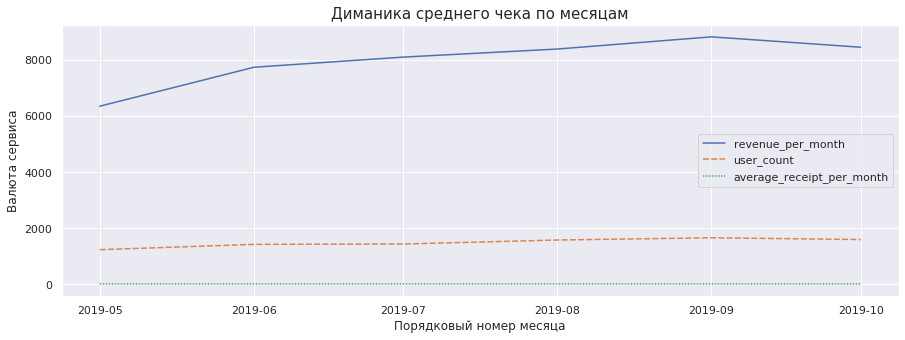

Средней чек за месяц составляет 5.38 или 107.82% от минимальной цены разовой покупки.


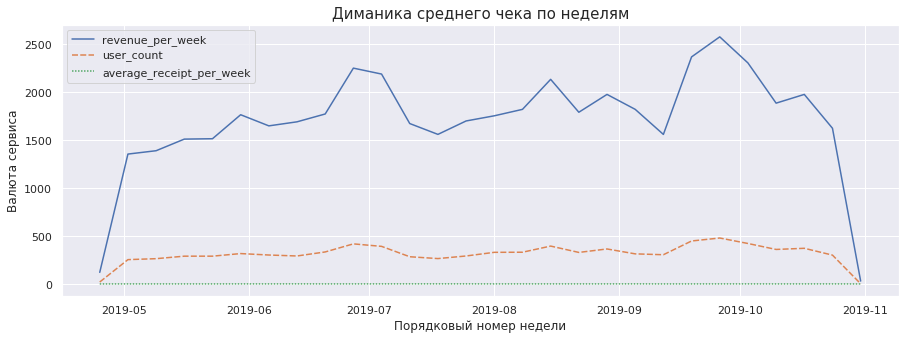

Средней чек за неделю составляет 5.36 или 107.47% от минимальной цены разовой покупки.


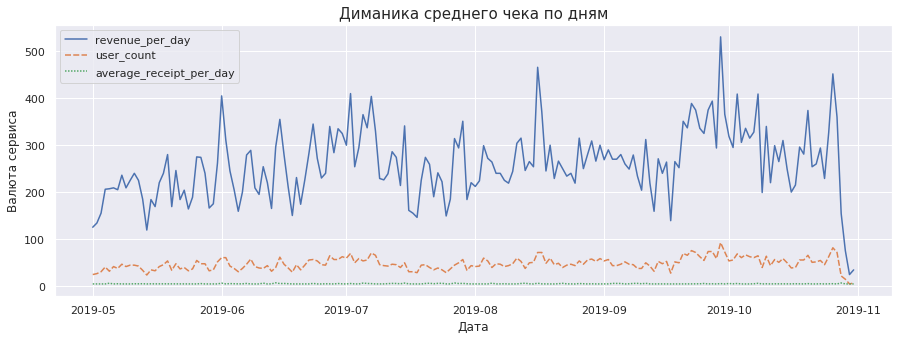

Средней чек за день составляет 5.38 или 107.8% от минимальной цены разовой покупки.


In [23]:
# рассчитываем средний чек за месяц
average_receipt_per_month = (
    profiles_purchase.groupby('event_month')
    .agg({'revenue': 'sum', 'user_id': 'nunique'})
    .assign(average_receipt_per_month = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_month', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по месяцам
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_month).set(xlabel='Порядковый номер месяца', ylabel='Валюта сервиса')
plt.title('Диманика среднего чека по месяцам', fontsize=15)
plt.show()

# вывод по размеру среднего чека за месяц
print(f"Средней чек за месяц составляет {average_receipt_per_month['average_receipt_per_month'].mean().round(2)} или {(average_receipt_per_month['average_receipt_per_month'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")

# рассчитываем средний чек за неделю
average_receipt_per_week = (
    profiles_purchase.groupby('event_week')
    .agg({'revenue': 'sum', 'user_id': 'nunique'})
    .assign(average_receipt_per_week = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_week', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по неделям
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_week).set(xlabel='Порядковый номер недели', ylabel='Валюта сервиса')
plt.title('Диманика среднего чека по неделям', fontsize=15)
plt.show()

# вывод по размеру среднего чека за неделю
print(f"Средней чек за неделю составляет {average_receipt_per_week['average_receipt_per_week'].mean().round(2)} или {(average_receipt_per_week['average_receipt_per_week'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")

# рассчитываем средний чек за день
average_receipt_per_day = (
    profiles_purchase.groupby('event_day')
    .agg({'revenue': 'sum', 'user_id': 'nunique'})
    .assign(average_receipt_per_day = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_day', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по дням
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_day).set(xlabel='Дата', ylabel='Валюта сервиса')
plt.title('Диманика среднего чека по дням', fontsize=15)
plt.show()

# вывод по размеру среднего чека за месяц
print(f"Средней чек за день составляет {average_receipt_per_day['average_receipt_per_day'].mean().round(2)} или {(average_receipt_per_day['average_receipt_per_day'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")



Итак, динамика месячной, недельной и дневной выручки за анализирумеый период положительная: с рстом числа платных пользователей растет и выручка, причем опережающими темпами, что свидетельствует как о совершении одним платящим пользователем нельскольких покупок, так и о совершении платящим пользователем одной покупки, но по цене выше минимальной стоимости услуги сервиса.

Так, средний чек за месяц 11,98 или 240% от минимальной цены покупки на сервесе; средний чек за неделю 7,13 или 143% от минимальной цены покупки на сервесе; средний чек за день 5,38 или 108% от минимальной цены покупки на сервисе.

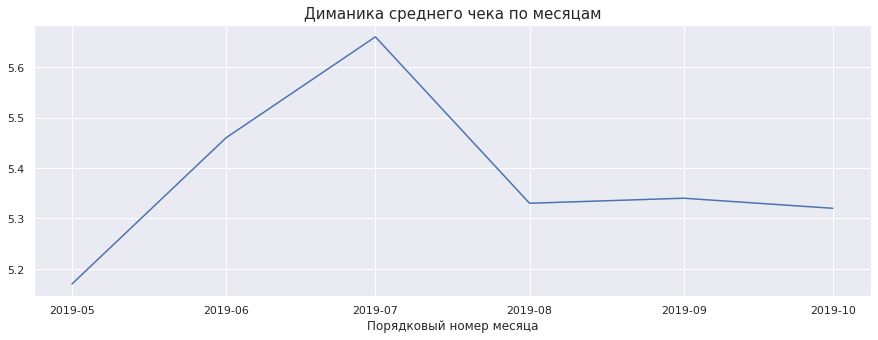

Средней чек за месяц составляет 5.38 или 107.82% от минимальной цены разовой покупки.


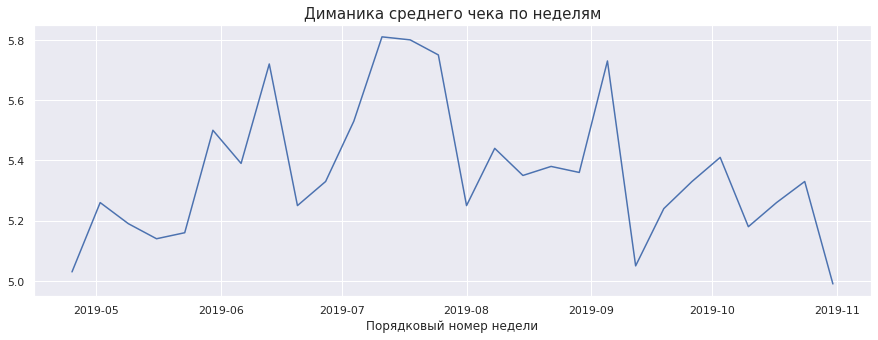

Средней чек за неделю составляет 5.36 или 107.47% от минимальной цены разовой покупки.


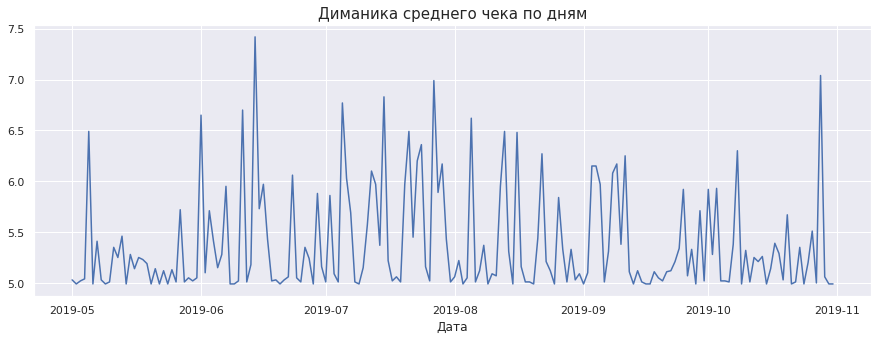

Средней чек за день составляет 5.38 или 107.8% от минимальной цены разовой покупки.


In [24]:
# рассчитываем средний чек за месяц
average_receipt_per_month = (
    profiles_purchase.groupby('event_month')
    .agg({'revenue': 'sum', 'user_id': 'count'})
    .assign(average_receipt_per_month = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_month', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по месяцам
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_month['average_receipt_per_month']).set(xlabel='Порядковый номер месяца')
plt.title('Диманика среднего чека по месяцам', fontsize=15)
plt.show()

# вывод по размеру среднего чека за месяц
print(f"Средней чек за месяц составляет {average_receipt_per_month['average_receipt_per_month'].mean().round(2)} или {(average_receipt_per_month['average_receipt_per_month'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")

# рассчитываем средний чек за неделю
average_receipt_per_week = (
    profiles_purchase.groupby('event_week')
    .agg({'revenue': 'sum', 'user_id': 'count'})
    .assign(average_receipt_per_week = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_week', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по неделям
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_week['average_receipt_per_week']).set(xlabel='Порядковый номер недели')
plt.title('Диманика среднего чека по неделям', fontsize=15)
plt.show()

# вывод по размеру среднего чека за неделю
print(f"Средней чек за неделю составляет {average_receipt_per_week['average_receipt_per_week'].mean().round(2)} или {(average_receipt_per_week['average_receipt_per_week'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")

# рассчитываем средний чек за день
average_receipt_per_day = (
    profiles_purchase.groupby('event_day')
    .agg({'revenue': 'sum', 'user_id': 'count'})
    .assign(average_receipt_per_day = lambda x: (x['revenue'] / x['user_id']).round(2))
    .rename(columns={'revenue': 'revenue_per_day', 'user_id': 'user_count'})
)
    
# визуализируем расчеты по дням
plt.figure(figsize=(15, 5))
sns.lineplot(data=average_receipt_per_day['average_receipt_per_day']).set(xlabel='Дата')
plt.title('Диманика среднего чека по дням', fontsize=15)
plt.show()

# вывод по размеру среднего чека за месяц
print(f"Средней чек за день составляет {average_receipt_per_day['average_receipt_per_day'].mean().round(2)} или {(average_receipt_per_day['average_receipt_per_day'].mean() / profiles_purchase['revenue'].min() * 100).round(2)}% от минимальной цены разовой покупки.")



### Маркетинг:

- Сколько денег потратили? Всего / на каждый источник / по времени

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds,TOTAL
costs_month,,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4,9978.570
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2,15090.045
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2,16447.060
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0,20657.870
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2,22441.340
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6,20882.415
TOTAL,3911.25,32445.6,1797.60,954.48,2151.25,1833.000,54751.3,5151.0,944.22,1557.6,105497.300


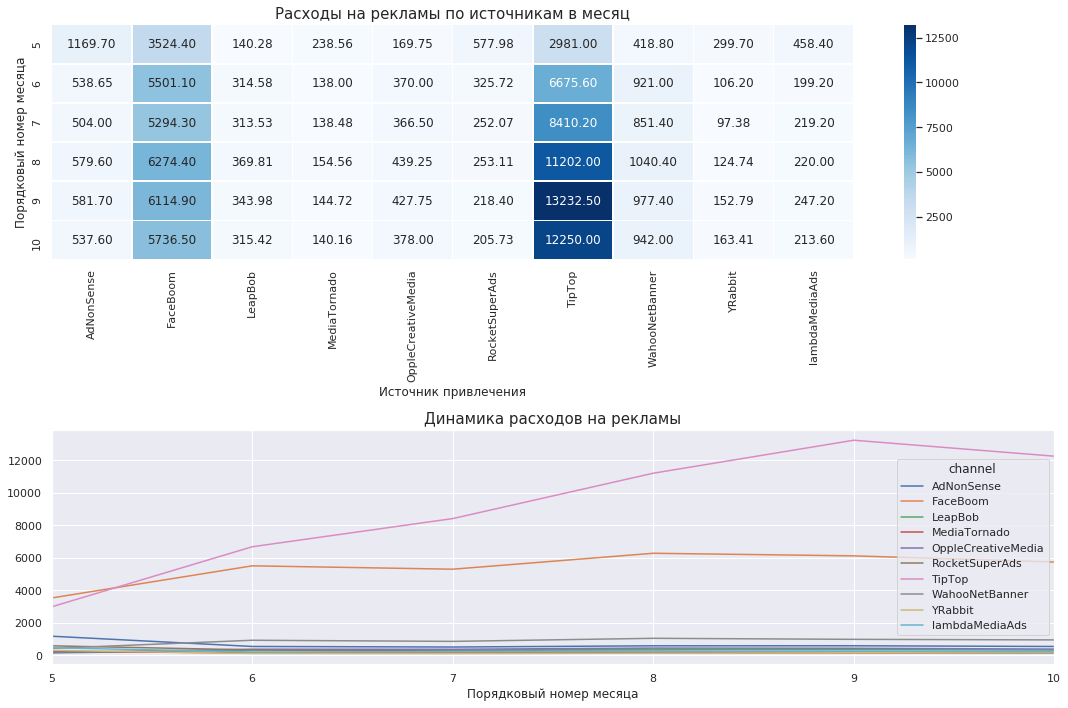

In [25]:
# выделяем месяц из данных о расходах на рекламу
costs['costs_month'] = costs['dt'].dt.month

# рассчитываем общие расходы на рекламу, детализируем по источникам и месяцам
display(costs.pivot_table(index='costs_month', 
                              columns='channel', 
                              values='costs', 
                              aggfunc='sum',
                             margins=True,
                             margins_name='TOTAL')
       )

# визуализируем расходы на рекламу в разрезе по источникам
plt.figure(figsize=(15, 10))

ax1=plt.subplot(2, 1, 1)
sns.heatmap(costs.pivot_table(index='costs_month', 
                              columns='channel', 
                              values='costs', 
                              aggfunc='sum'),
            annot=True,
            fmt='.2f',
            cmap='Blues', 
            linewidths=.5,
           ax=ax1)
ax1.set_xlabel('Источник привлечения')
ax1.set_ylabel('Порядковый номер месяца')
plt.title('Расходы на рекламы по источникам в месяц', fontsize=15)

# визуализируем расходы на рекламу в динамике
ax2=plt.subplot(2, 1, 2)
(
    (costs.pivot_table(index='costs_month', columns='channel', values='costs', aggfunc='sum'))
    .plot(ax=ax2)
)
ax2.set_xlabel('Порядковый номер месяца')
plt.title('Динамика расходов на рекламы', fontsize=15)

plt.tight_layout()

plt.show()

Таким образом, за анализируемый период общие расходы на рекламу составили 105497.30.

Среди рекламных источников лидерами по освоению средств стали TipTop - 54751.30 и FaceBoom - 32445.60 (эти же источники выделяються по размеру рекламных бюджетов на протяжении всего анализируемого периода), аутсайдерами, - MediaTornado - 954.48 и YRabbit - 944.22.

Больше всего средств потрачено в сентябре - 22441.34, меньше всего, - в мае - 9978.57. Общая тенденция - рост рекламных расходов за анализируемый период. 

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

In [26]:
# обогощаем фрейм с данными профилей пользователей сведениями о стоимости привлечения каждого пользователя

# выделяем дату из столбца фрема profiles и преобразовываем в необходимый формат 
# для последующего объединения с фреймом costs
profiles['dt'] = profiles['first_ts'].dt.date
profiles['dt'] = pd.to_datetime(profiles['dt'])

# считаем количество уникальных пользователей с одинаковыми источником и датой привлечения
new_users = (
    profiles.groupby(['dt', 'channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_users'})
    .reset_index()
)

# объединяем расходы на рекламу и число привлечённых пользователей
costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

# рассчитывем стоимость привлечения пользователя
costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

# добавляем стоимость привлечения в фрейм с профилями пользователей
profiles = profiles.merge(
    costs[['dt', 'channel', 'acquisition_cost']],
    on=['dt', 'channel'],
    how='left'
)

# стоимость привлечения органических пользователей равна нулю
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

# профили пользователей сервиса
profiles.head()

,user_id,first_ts,region,device,channel,payer,dt,acquisition_cost
0,599326,2019-05-07 20:58:00,United States,Mac,FaceBoom,1,2019-05-07,1.088172
1,4919697,2019-07-09 12:46:00,United States,iPhone,FaceBoom,0,2019-07-09,1.107237
2,6085896,2019-10-01 09:58:00,France,iPhone,Organic,0,2019-10-01,0.000000
3,22593348,2019-08-22 21:35:00,Germany,PC,AdNonSense,0,2019-08-22,0.988235
4,31989216,2019-10-02 00:07:00,United States,iPhone,YRabbit,0,2019-10-02,0.230769


,channel,acquisition_cost,number_of_aquisition_users
0,TipTop,2.799003,19561
1,FaceBoom,1.113286,29144
2,AdNonSense,1.008054,3880
3,lambdaMediaAds,0.724802,2149
4,WahooNetBanner,0.602245,8553
5,RocketSuperAds,0.412095,4448
6,OppleCreativeMedia,0.250000,8605
7,YRabbit,0.218975,4312
8,MediaTornado,0.218717,4364
9,LeapBob,0.210172,8553


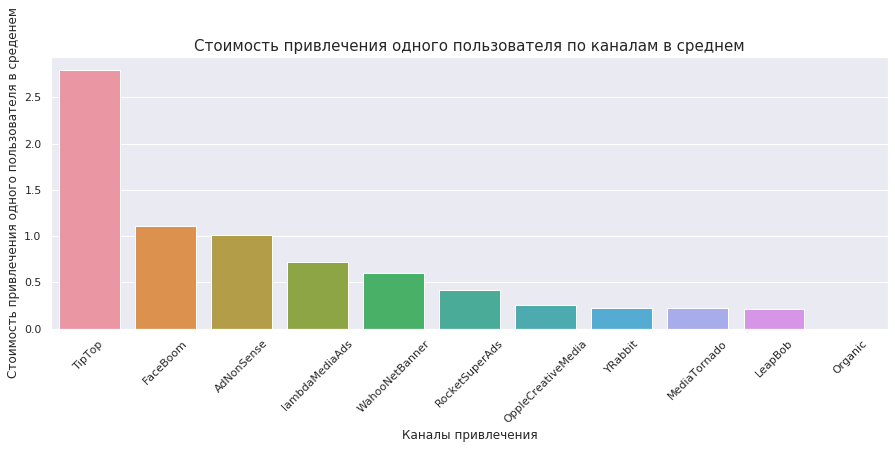

In [27]:
# рассчитываем среднюю стоимость привлечения пользователя из каждого источника
average_aquisition_cost = (
    profiles
    .groupby('channel')
    .agg({'acquisition_cost': 'mean', 'user_id': 'nunique'})
    .rename(columns={'user_id': 'number_of_aquisition_users'})
    .sort_values(by='acquisition_cost', ascending=False)
    .reset_index()
)

# средняя стоимость привлечения пользователя из каждого источника
display(average_aquisition_cost)

# визуализируем расчеты
plt.figure(figsize=(15, 5))

(
    sns.barplot(data=average_aquisition_cost, x='channel', y='acquisition_cost')
        .set(
        xlabel='Каналы привлечения',
        ylabel='Стоимость привлечения одного пользователя в среденем'
    )
)
plt.title('Стоимость привлечения одного пользователя по каналам в среднем', fontsize=15)
plt.xticks(rotation=45)

plt.show()

Итак, за анализируемый период, самые дорогие привлеченные пользователи сервиса пришли от сетей TipTop и FaceBoom (2,80 и 1,11 соответсвенно) эти же сети являються лидерами по количеству привлеченных пользователей (19561 и 29144 соответсвенно).

Дешевле всего обошлись пользователя от YRabbit и LeapBob (по 0,22 и 0,21 за одного лида соответсвенно), при YRabbit привлек 4312 пользователя, а LeapBob 8553.

Бесплатно сервису достались 56439 пользователей.

**Выводы**

В ходе анализа продукта, продаж и маркетинга установлено следующее:

01 мая 2019 года были привлечены первые пользователи за анализируемый период, с этого момента начинаеться рост количества сессий в день.

27 октября 2019 года последний день привлечения новых пользователей за анализируемый период, их активность к началу ноября падает, а новых пользоватлей в данных нет, в связи с чем количество сессий резко снижаеться.

В целом, заметен тренд на увеличение количества сессий в день с пиком в 2493 посещения 29 сентября 2019 года.

Часть сессий (порядка 15000) имеют продолжительность близкую к 0 сек., что представляеться возможным трактовать, как ошибочные входы пользователей на сервис, так и наличием технических ошибок (сессии заканчиваються принудительно).

Сессии превышающие 6750 сек. (1,5 межквартильного размаха) после консультации с продакт-менеджером об особенность сервиса, возможно, признать аномально длительными (либо пользователь не завершил сессию, либо техническая ошибка).

В среднем пользователю требуется 32 дня для принятие решения о покупки, при этом половина пользователей совершают покупку на 16-й день пользования сервисом, а максимальное время принятия решения о покупке за анализируемый период составляет 183 дня.

На месячном и недельном временном диапазоне среднего числа покупок заметен опережающий рост количества покупок, над приростом количества платящих пользователей, что является положительным моментом для сервиса, - большинство платящих пользователей в масшатбе месяца и недели совершает более одной покупки. Что подтвержаеться расчетами: 2,23 покупки в среднем в месяц, 1,33 покупки в среднем в неделю.

Динамика среднех дневных покупок демонстрирует равным прирост платящих пользователей и количество покупок, среднее число покупок в день 1,0. Действительно, в отфильтрованных данных по признаку совершения хотя бы одной покупки за анализируемый период, каждый платящий пользователь не мог совершить меньше одной покупки.

Динамика месячной, недельной и дневной выручки за анализирумеый период положительная: с ростом числа платных пользователей растет и выручка, причем опережающими темпами, что свидетельствует как о совершении одним платящим пользователем нельскольких покупок, так и о совершении платящим пользователем одной покупки, но по цене выше минимальной стоимости услуги сервиса.

Так, средний чек за месяц 11,98 или 240% от минимальной цены покупки на сервесе; средний чек за неделю 7,13 или 143% от минимальной цены покупки на сервесе; средний чек за день 5,38 или 108% от минимальной цены покупки на сервисе.

Общие расходы на рекламу составили 105497.30.

Среди рекламных источников лидерами по освоению средств стали TipTop - 54751.30 и FaceBoom - 32445.60 (эти же источники выделяються по размеру рекламных бюджетов на протяжении всего анализируемого периода), аутсайдерами, - MediaTornado - 954.48 и YRabbit - 944.22.

Больше всего средств потрачено в сентябре - 22441.34, меньше всего, - в мае - 9978.57. Общая тенденция - рост рекламных расходов за анализируемый период.

Самые дорогие привлеченные пользователи сервиса пришли от сетей TipTop и FaceBoom (2,80 и 1,11 соответсвенно) эти же сети являються лидерами по количеству привлеченных пользователей (19561 и 29144 соответсвенно).

Дешевле всего обошлись пользователя от YRabbit и LeapBob (по 0,22 и 0,21 за одного лида соответсвенно), при YRabbit привлек 4312 пользователя, а LeapBob 8553.

Бесплатно сервису достались 56439 пользователей.

# Шаг 4. Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [28]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [29]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [30]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [31]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [32]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    ax1.set_xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    ax2.set_xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    ax3.set_xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    ax4.set_xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [33]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    ax1.set_xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    ax2.set_xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [34]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    ax1.set_xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    ax2.set_xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    ax3.set_xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    ax4.set_xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    ax5.set_xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

LTV и ROI:
- Анализ общей окупаемость рекламы;
- Анализ окупаемости рекламы с разбивкой по устройствам;
- Анализ окупаемости рекламы с разбивкой по странам;
- Анализ окупаемости рекламы с разбивкой по рекламным каналам.

### Анализ общей окупаемости рекламы

Итак, на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [35]:
observation_date = datetime(2019, 11, 1).date() # момент анализа
horizon_days = 14 # горизонт анализа
profiles_paid = profiles.query('channel != "Organic"') # исключаем пользователей, которые достались сервису "бесплатно"

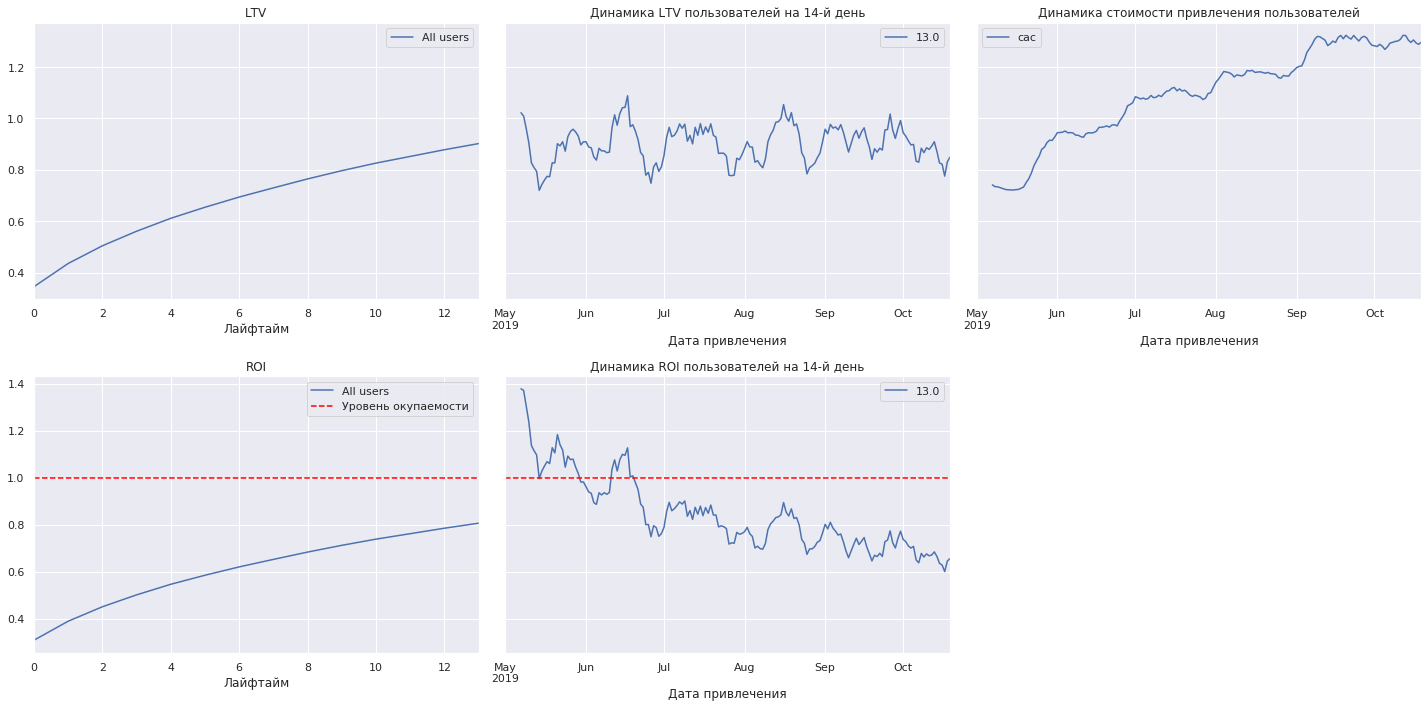

In [36]:
# рассчитываем общие LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days
)

# визуализируем расчеты
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

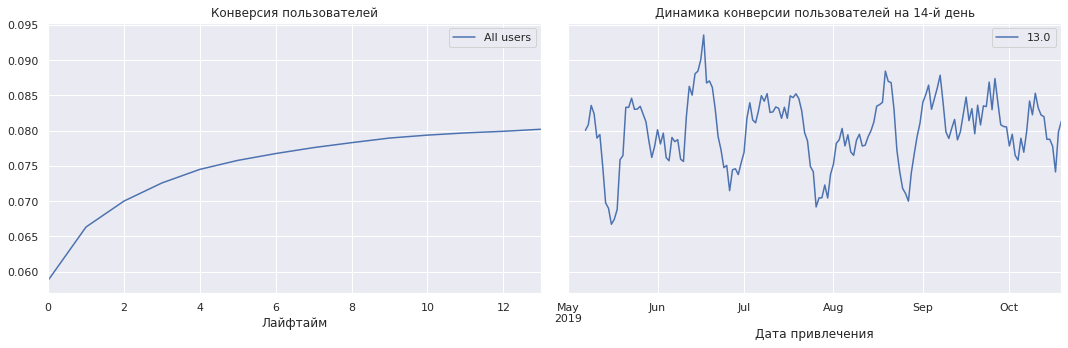

In [37]:
# расчитываем общую конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days
)

# визуализируем расчеты
plot_conversion(conversion_grouped, conversion_history, horizon_days)

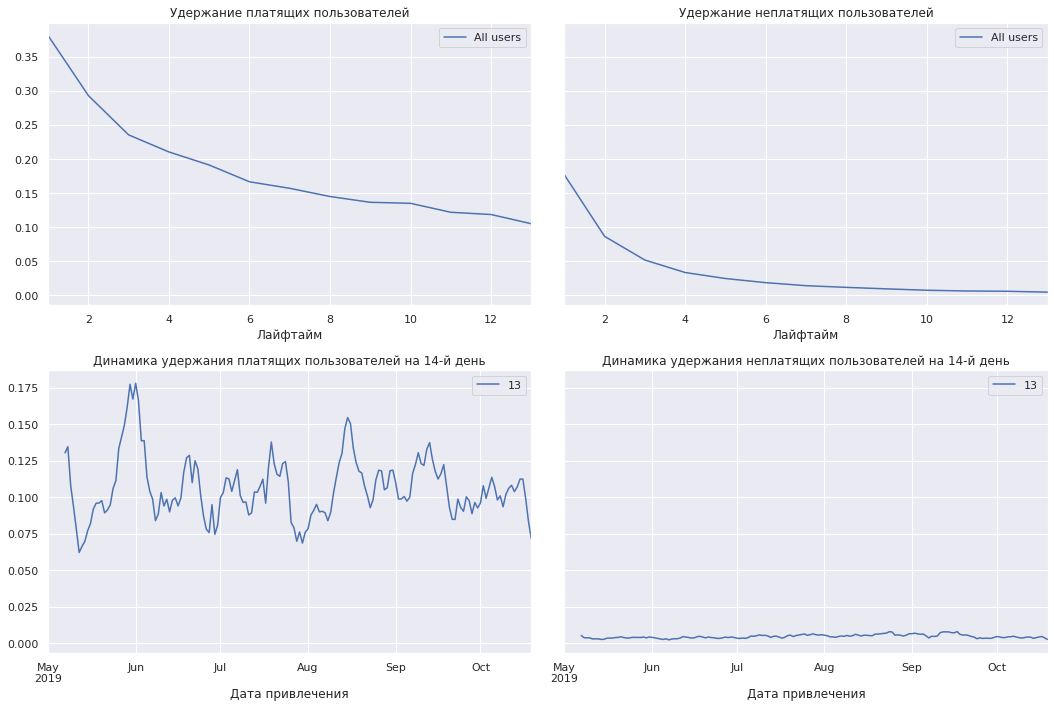

In [38]:
# рассчитывем общее удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days
)

# визуализируем расчеты
plot_retention(retention_grouped, retention_history, horizon_days)

Итак,

1. График LTV демонстрирует, что при глубине анализа в 14 дней, 142620 пользователя сервиса начинают генерировать выручку на первый день в среднем в размере около 0,24 и к концу второй недели, накопительным итогом, выручка достигает показателя в размере около 0,68.

2. График Динамики LTV пользователей на 14-й день демонстрирует, что из 172-х когорт привлеченных пользователей "проживших" в сервисе две недели, лучшие результаты по выручке сервису показали клиенты привлеченные в середине июня (примерно 0,85 выручка по клиенту в среднем накопительным итогом) и в конце сентября (примерно 0,81 выручка по клиенту в среднем накопительным итогом).

3. График Динамики стоимости привлечения клиентов (САС) демонстритует постоянный рост рекламных расходов, что было отмечено ранее в исследовании. САС имеет резкий рост к началу июня к отметке примерно в 0,78 и к концу анализируемого периода плавно увеличиваеться, в плотную приближаясь к отметке в 1,4.

Таким образом, по пунктам 1-3 вывода, в среднем ценность каждого клиента сервиса на 14-й день "жизни" не превышает 0,7, при этом расходы на привлечения пользователя уже в мае превысили отметку в 0,8 (пользователи, начиная с мая, в среднем за две недели приносят сервису меньше денег, чем сервис инвестирует в их привлечение), при этом даже наиболее "платящие" июньские и сентябрьские когорты пользователей начиная с сентября перестают приносить сервису прибыль (с сентября стоимость привлечения клиента начинает превышать отметку примерно в 1,2, при доходной части от указанных когорот не более 1,1).

4. График ROI демонструет и подтверждает ранее сделанный вывод об отсутвии рентабельности: за две недели присутствия в сервисе клиенты не достигли окупаемости вложений в их привлечение.

5. График динамики ROI демонстрирует и подтвержтает, что только когорты пользователей привлеченные до конца июня имеют процент возврата на инвестиции в маркетинг отличный от нуля. Начиная с конца июля, рентабельность инвестиций в маркетинг не превыли нуль.

6. Конверсия пользователей сервиса к концу второй недели пребывания в сервисе вплотную приближаеться к отметки в 0,8, таким образом более 80% привлеченных клиентов совершили хотя бы одну покупку на сервисе.

7. Наибольшая конверсия отмечена у июньских и августо-сентябрьских когорт, практически 95% и более 90% соответсвенно клиентов стали платящими, что подтверждает выводы п.2 и п.5. После ухода с сервиса этих когорт, кампания становиться убыточной.

8. Кроме того, удержание платящих пользователей к концу второй недели снижаеться до примерно 12% (более 88% плательщиков покунули сервис к дедлайну по окупаемости).

9. Лучшее удержание, как прочие ключевые метрики (пп. 2, 5, 7 вывода) продемострировали июньские когорты 17,5% этих пользователей остались верны сервису на 14-й день.

Таким образом, при дальнейшим анализе особое внимаение следует уделить:

- отсутвие рентабельности маркетинговых вложений по сервису в целом за анализируемый период;

- постоянный и стремительный рост рекламных расходов в целом по сервису за анализирумеый период;

- точкой отсчета опережения рекламных расходов (САС - стоимость привлечения лида) над ценностью привлекаемых пользоватлей (LTV - показатель выручки с польщователя сервиса) считать конец августа;

- точкой отсчета потери возврата на инвестиции считать конец июля;

- лучшие показатели по LTV, ROI, retention и conversion зафиксированы у июньско-июльских когорт.

Далее изучим ключевые метрики в разрезах по устройствам, географическому признаку, каналам привлечения. Установим убыточные факторы, отметим возможные точки роста.

### Анализ окупаемости рекламы с разбивкой по устройствам

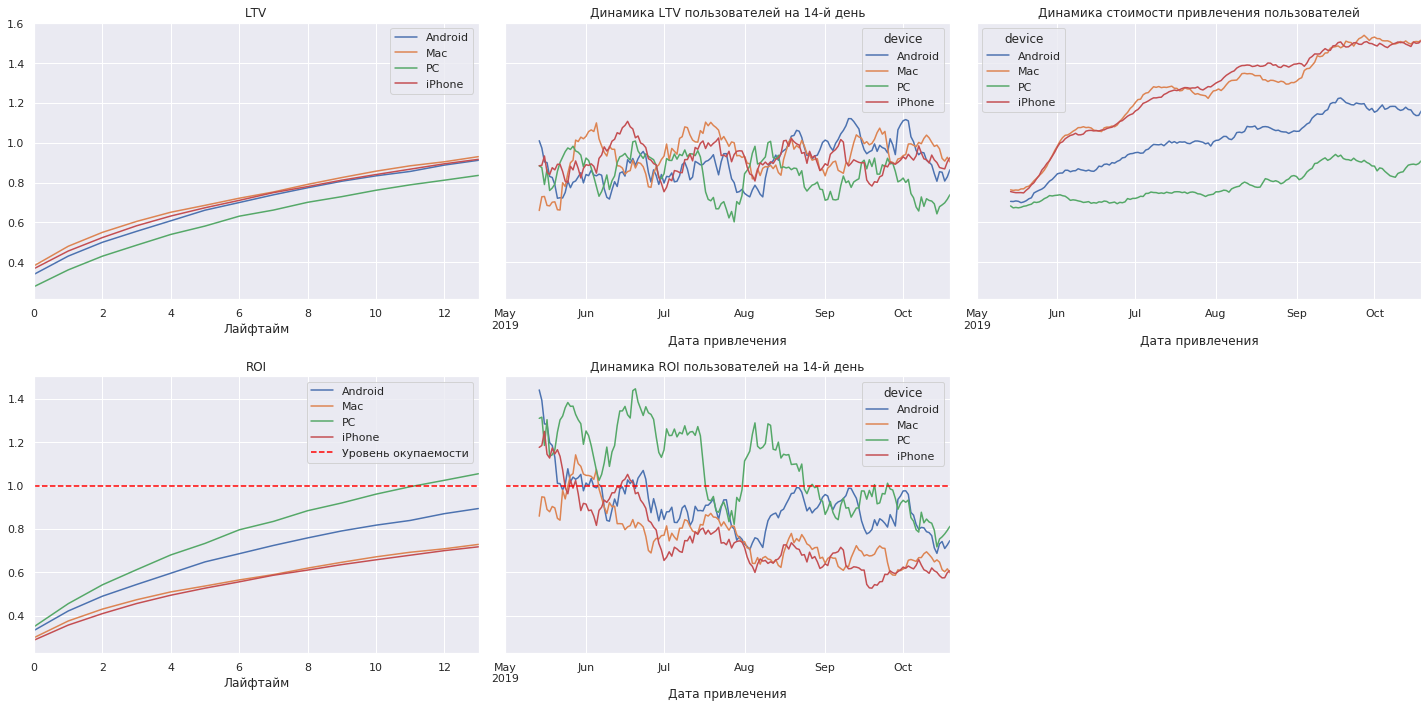

In [39]:
# окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

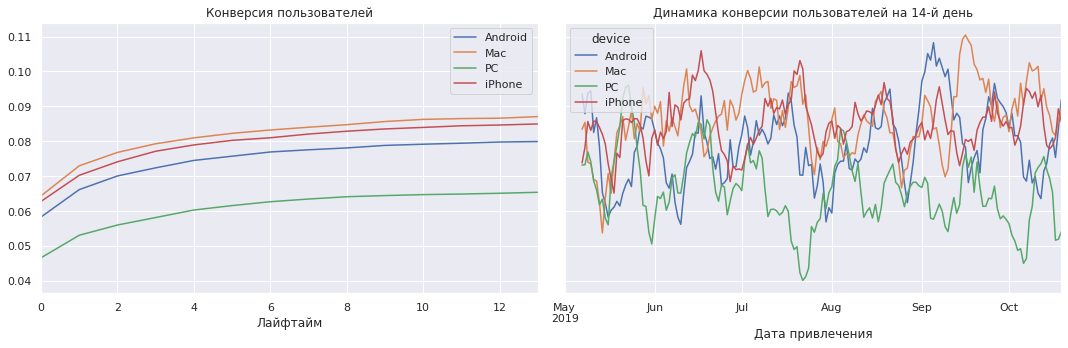

In [40]:
# конверсия с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_conversion(conversion_grouped, conversion_history, horizon_days)

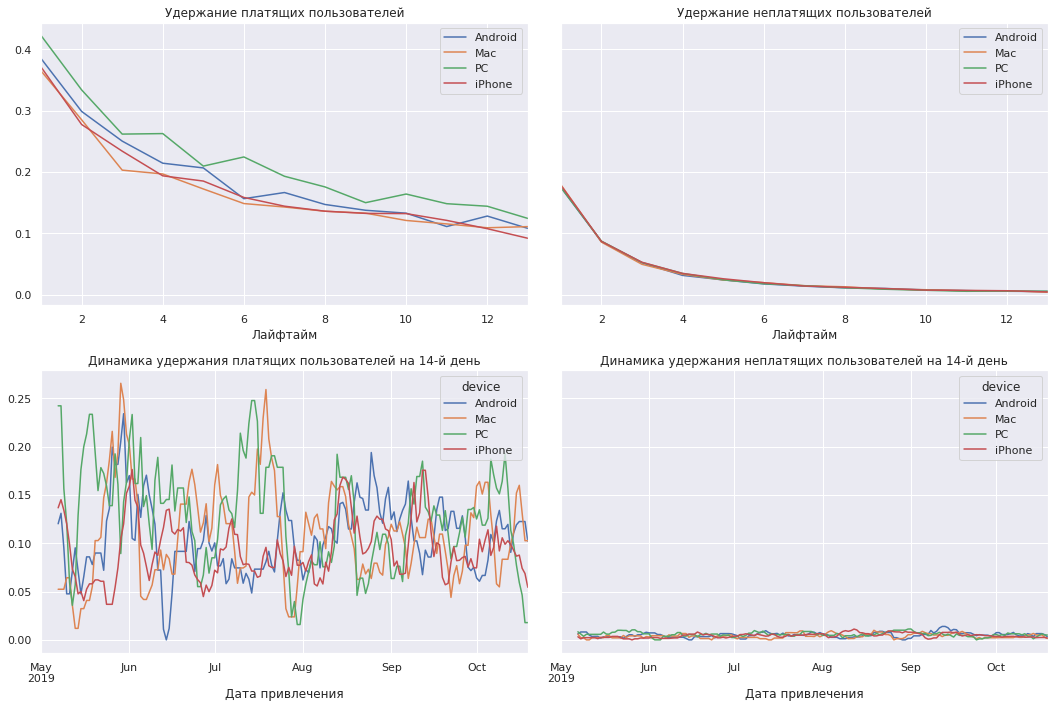

In [41]:
# удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=['device']
)

# визуализируем расчеты
plot_retention(retention_grouped, retention_history, horizon_days)

Итак,

1. Медленне всего накопительным итогом растет ценность пользователей сервиса с РС, одна же являеться минимальной и не превышает отметку в 0,82. Пользователи Android, Mac и iPhone практически находяться в равных позициях.

2. На конец второй недели пользователи всех устройств занимают коридор по выручке в диапазоне от 0,6 до 1,1. При этом лучшие показатели продемонстрировали майские и июньские когорты на Мас (1,1 по по обеим когортам), худшие - июльские и октябрьские пользователи РС (по 0,6 каждая).

3. Дороже всего сервису обходится привлечение пользователей на Mac и iPhone: скорость роста стоимости привлечении больше всего и на конец анализируемого периода пробивает отметку в 1,5 и с июня перестает быть рентабельной (LTV указанных категорий пользователей не более 1,1 при САС более 1,2). Дешевле всего сервису обходяться владельцы РС, по цене не выше 0,8 для пользователей, привлеченных на сервис в середине сентября, при выручке по этим пользователям сопоставим с затрами в этот период и пиковой выручкой в 1,0 для майских, июньских, августовских когорт. Пользователи Android перестают окупаться с сентября: LTV не более 1,1 при САС более 1,2.

4. За счет того, что стоимость привлечения пользователей на РС наименьшая и эти же пользователи, в целом, попадают в коридор LTV между 0,6 и 1,1 на конец второй недели пользования сервисом, только по ним рентабельнось превышает 0% и составляет порядка 8%.

5. До июня рентабельный были все пользователи сервиса (сегрегированные в данном параграфе по устройствам). К концу июня привлечения пользователей Mac, iPhone и Android стало убыточно. Кроме того, к концу анализируемого периода, рентабельность когорт на РС также стала снижать и несколько раз пробивала порог окупаемости. С сентября все категории устройств платных пользователей сервиса перестают приносить прибыль сервису.

Таким образом, по пунктам 1-5 вывода, владельцы РС - наиболее привлекательны для сервиса.

6.Однако, конверсия пользователей РС - самая низкая из всех устройств, не более 0,065 (не более 6,5% пользователей РС становиться покупателями).

7. При том, что лучшую конверсию (примерно 11%) продемострировали пользователи Мас и Android, привлеченные в сентябре.

8. В то же время пользователи РС остаються верны сервису на конец двухнедельного срока на равне с польщователями МАС - практически 25% для июльской когорты и практически 14% в среднем по сервису.

Таким образом, при низкой конверсии пользователей РС, высокие показатели удержания в совакупности с низкой стоимостью привлечения деляют последних лидерами среди клиентов сервиса. Выводы пп. 1-5 подтверждены. 

Таким образом, стоит рекомендовать маркетологам уделить привлечению пользователей РС в сервис, а польщователи MAC и iPhone наиболее убыточны для платформы.

Далее изучим географию пользователей сервиса.

### Анализ окупаемости рекламы с разбивкой по странам

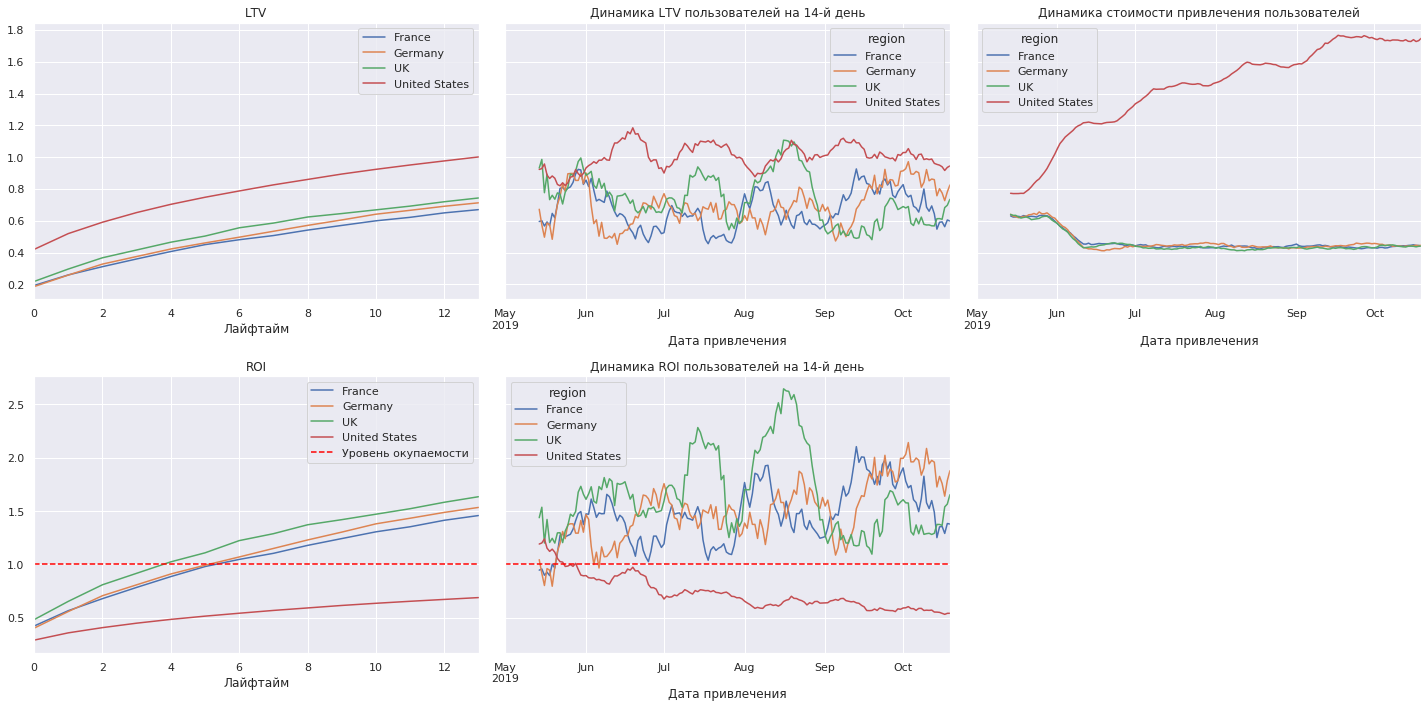

In [42]:
# окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

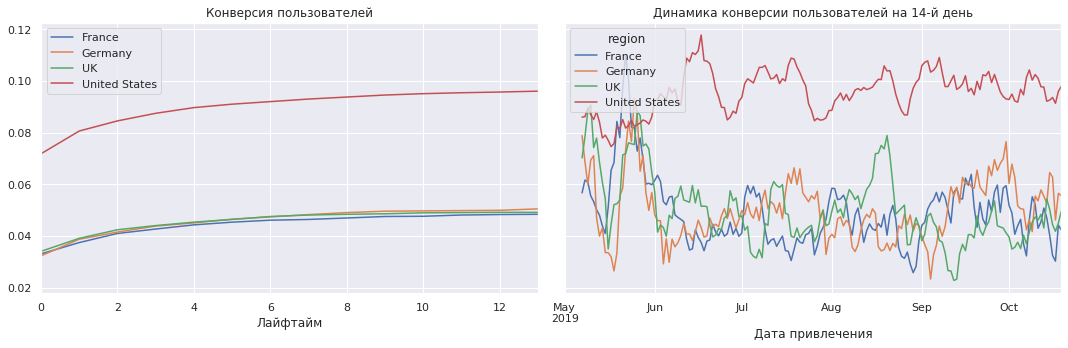

In [43]:
# конверсия с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_conversion(conversion_grouped, conversion_history, horizon_days)

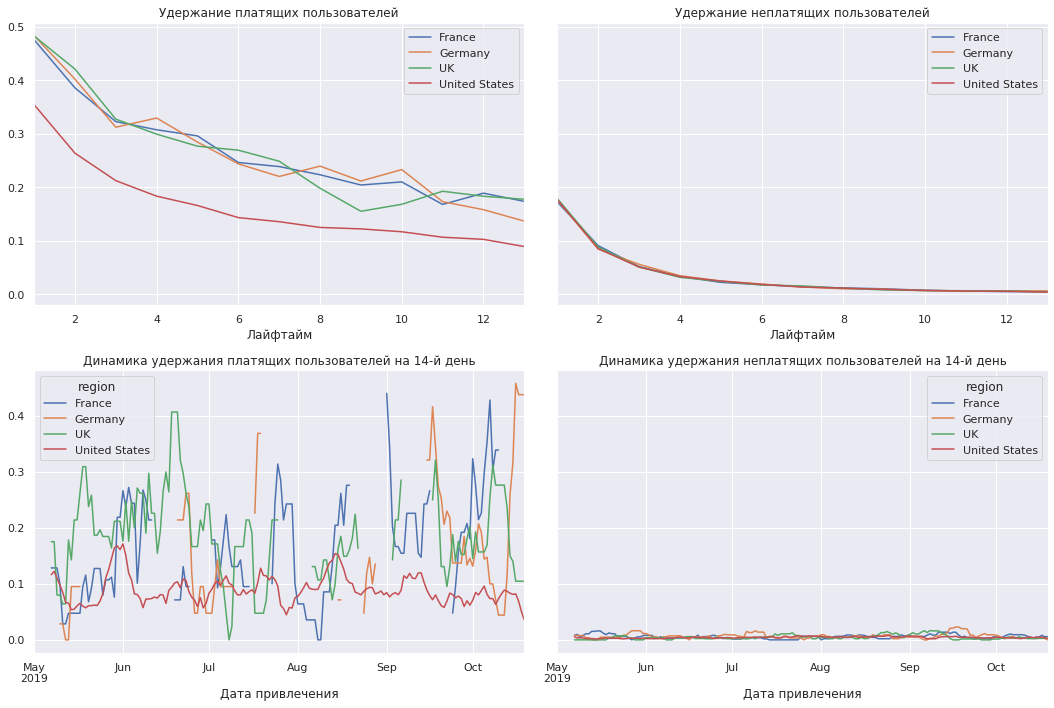

In [44]:
# удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=['region']
)

# визуализируем расчеты
plot_retention(retention_grouped, retention_history, horizon_days)

Итак,

1. Лидером по показателю LTV являються пользователи сервисом с территории Соединенных Штатов. Выручка обозначенных пользователей на конец второй недели в среднем достигает отметки 1,0, в то время, как прочие пользователи (с территорий Франции, Германии и Соединенного Королевства) приближаться в среднем к отметки в 0,8. Аутсайдерами являються пользователи сервиса совершившие первый вход с территории Франции, LTV куммулятивно на 14-й день, чуть более 0,6.

2. Среди когорт, лидерами также являються пользователи сервиса с территории США, с пиком в примерно 1,2 когортой привлеченной в середине июня. Однако, когорта немецких пользователей из Великобритании в середине августа обгоняет северо-американских пользователей в отметке примерно в 1,1.

3. Стоимость привлечения пользователей Соединенных Штатов явно дороже всех прочих: экпоненциальный рост с пиком близком к 1,9 в сентярбре. В то время, как привлечение прочих пользователей обходиться сервису не дороже примерно 0,5 на протяжение всего анализируемого периода.

4. В связи с повышенной стоимотью привлечения американских пользователей, данная категория имеет ROI меньше единица, в то время как маркетинговая рентабельность французов и немцев практически 50%, а англичан, практически 70%.

5. С июня привлекать пользователей с территории США сервису не выгодно, у прочих пользователей за весь анализируемый период рентабельность не пробивала порог окупаемости, а пиками роста в 125% и 170% стали июльские и августовские когорты англичан.

Таким образом, по пунктам 1-5 вывода, пользователи совершившие первый вход в сервис с территории Соединенных Штатов убыточны для сервиса. Пользователи, совершившие вход с териитории Соединенного Королевства наиболее привлекательны для сервиса.

6. В то же время практически 10% пользователей из США совершают хотя бы одну покупку на сервисе за весь анализируемый период в среднем и практически 12% пользователей июльской когорты стали плательщиками, при среднем значении в 5% для прочих категорий пользователей в разреше географии сервиса.

7. Однако, американцы быстрее всего покидают сервис, около 10% остаются пользователямя к концу второй недели, при средней оценки по сервису в 15-20%.

Таким образом, не смотря на высокую конверсию пользователей из США, низкое удержание в совакупности с выской стоимостью привлечения делает последних не привлекательными для сервиса. Маркетологам стоит исключить клиентов из Соединенных Штатов из целевой аудитории сервиса и больше внимание уделить Великобритании.

Изучим каналы привлечения пользователей.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

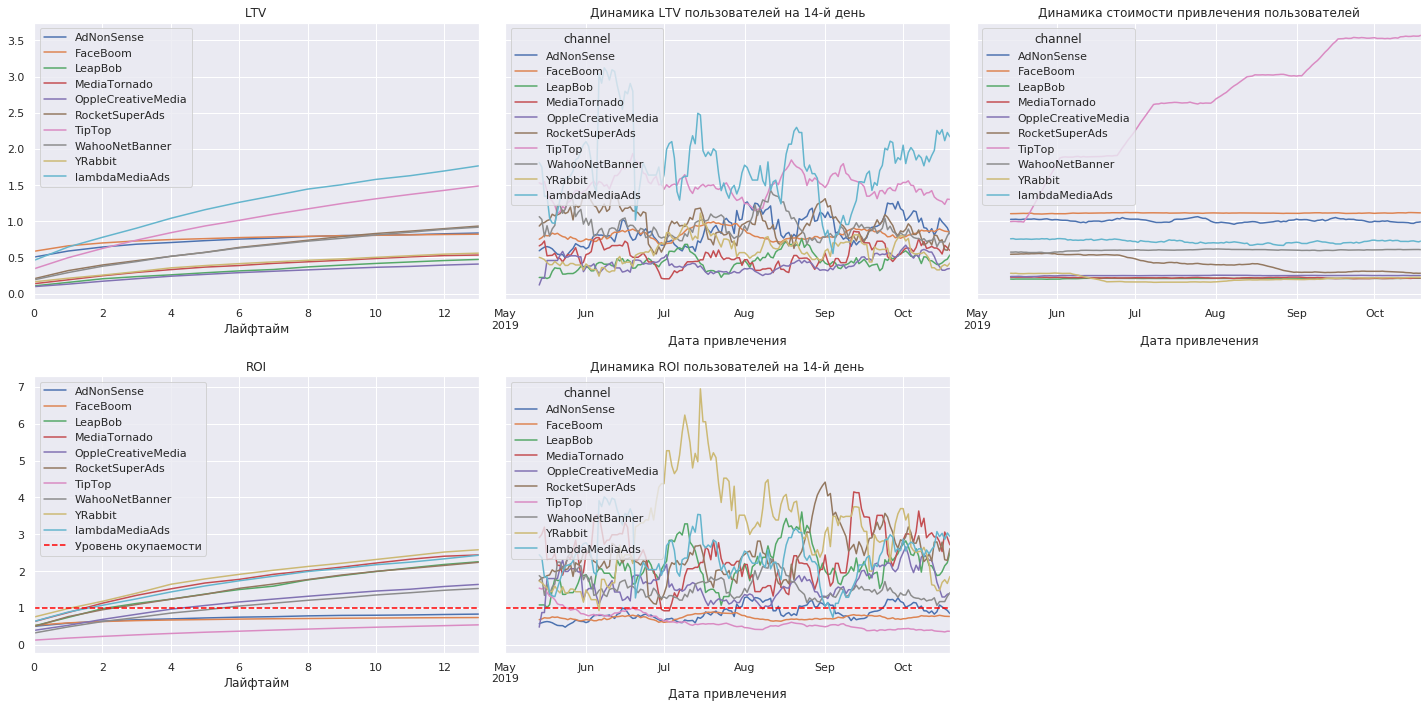

In [45]:
# окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

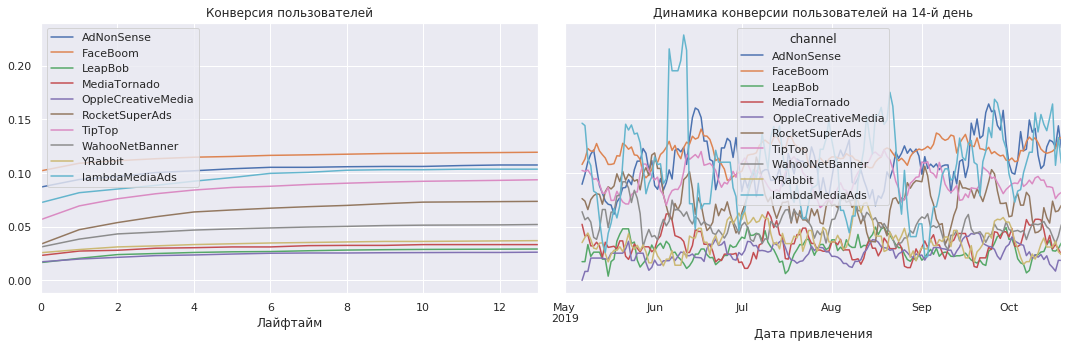

In [46]:
# конверсия с разбивкой по каналам привлечения
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

# визуализируем расчеты
plot_conversion(conversion_grouped, conversion_history, horizon_days)

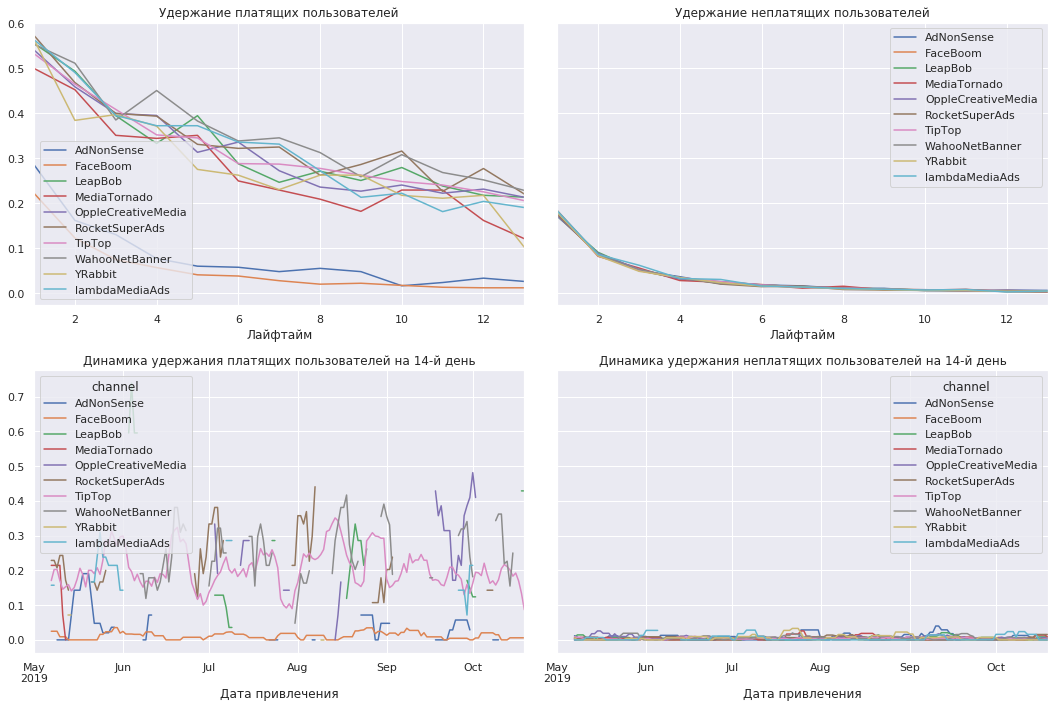

In [47]:
# удержание с разбивкой по каналам привлечения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=['channel']
)

# визуализируем расчеты
plot_retention(retention_grouped, retention_history, horizon_days)

**Выводы**

График общего LTV по сервису демонстрирует, что при глубине анализа в 14 дней, 142620 пользователя сервиса начинают генерировать выручку на первый день в среднем в размере около 0,24 и к концу второй недели, накопительным итогом, выручка достигает показателя в размере около 0,68.

График Динамики LTV пользователей на 14-й день демонстрирует, что из 172-х когорт привлеченных пользователей "проживших" в сервисе две недели, лучшие результаты по выручке сервису показали клиенты привлеченные в середине июня (примерно 0,85 выручка по клиенту в среднем накопительным итогом) и в конце сентября (примерно 0,81 выручка по клиенту в среднем накопительным итогом).

График Динамики стоимости привлечения клиентов (САС) демонстритует постоянный рост рекламных расходов, что было отмечено ранее в исследовании. САС имеет резкий рост к началу июня к отметке примерно в 0,78 и к концу анализируемого периода плавно увеличиваеться, в плотную приближаясь к отметке в 1,4.

График ROI демонструет и подтверждает ранее сделанный вывод об отсутвии рентабельности: за две недели присутствия в сервисе клиенты не достигли окупаемости вложений в их привлечение.

График динамики ROI демонстрирует и подтвержтает, что только когорты пользователей привлеченные до конца июня имеют процент возврата на инвестиции в маркетинг отличный от нуля. Начиная с конца июля, рентабельность инвестиций в маркетинг не превыли нуль.

Конверсия пользователей сервиса к концу второй недели пребывания в сервисе вплотную приближаеться к отметки в 0,8, таким образом более 80% привлеченных клиентов совершили хотя бы одну покупку на сервисе.

Наибольшая конверсия отмечена у июньских и августо-сентябрьских когорт, практически 95% и более 90% соответсвенно клиентов стали платящими, что подтверждает выводы п.2 и п.5. После ухода с сервиса этих когорт, кампания становиться убыточной.

Кроме того, удержание платящих пользователей к концу второй недели снижаеться до примерно 12% (более 88% плательщиков покунули сервис к дедлайну по окупаемости).

Лучшее удержание, как прочие ключевые метрики продемострировали июньские когорты 17,5% этих пользователей остались верны сервису на 14-й день.

Особое внимаение следует уделить:

- отсутвие рентабельности маркетинговых вложений по сервису в целом за анализируемый период;

- постоянный и стремительный рост рекламных расходов в целом по сервису за анализирумеый период;

- точкой отсчета опережения рекламных расходов (САС - стоимость привлечения лида) над ценностью привлекаемых пользоватлей (LTV - показатель выручки с польщователя сервиса) считать конец августа;

- точкой отсчета потери возврата на инвестиции считать конец июля;

- лучшие показатели по LTV, ROI, retention и conversion зафиксированы у июньской когорты.

Медленне всего накопительным итогом растет ценность пользователей сервиса с РС, одна же являеться минимальной и не превышает отметку в 0,82. Пользователи Android, Mac и iPhone практически находяться в равных позициях.

На конец второй недели пользователи всех устройств занимают коридор по выручке в диапазоне от 0,6 до 1,1. При этом лучшие показатели продемонстрировали майские и июньские когорты на Мас (1,1 по по обеим когортам), худшие - июльские и октябрьские пользователи РС (по 0,6 каждая).

Дороже всего сервису обходится привлечение пользователей на Mac и iPhone: скорость роста стоимости привлечении больше всего и на конец анализируемого периода пробивает отметку в 1,5 и с июня перестает быть рентабельной (LTV указанных категорий пользователей не более 1,1 при САС более 1,2). Дешевле всего сервису обходяться владельцы РС, по цене не выше 0,8 для пользователей, привлеченных на сервис в середине сентября, при выручке по этим пользователям сопоставим с затрами в этот период и пиковой выручкой в 1,0 для майских, июньских, августовских когорт. Пользователи Android перестают окупаться с сентября: LTV не более 1,1 при САС более 1,2.

За счет того, что стоимость привлечения пользователей на РС наименьшая и эти же пользователи, в целом, попадают в коридор LTV между 0,6 и 1,1 на конец второй недели пользования сервисом, только по ним рентабельнось превышает 0% и составляет порядка 8%.

До июня рентабельный были все пользователи сервиса (сегрегированные в данном параграфе по устройствам). К концу июня привлечения пользователей Mac, iPhone и Android стало убыточно. Кроме того, к концу анализируемого периода, рентабельность когорт на РС также стала снижать и несколько раз пробивала порог окупаемости. С сентября все категории устройств платных пользователей сервиса перестают приносить прибыль сервису.

Однако, конверсия пользователей РС - самая низкая из всех устройств, не более 0,065 (не более 6,5% пользователей РС становиться покупателями).

При том, что лучшую конверсию (примерно 11%) продемострировали пользователи Мас и Android, привлеченные в сентябре.

В то же время пользователи РС остаються верны сервису на конец двухнедельного срока на равне с польщователями МАС - практически 25% для июльской когорты и практически 14% в среднем по сервису.

Особое внимание следует уделить:

- при низкой конверсии пользователей РС, высокие показатели удержания в совакупности с низкой стоимостью привлечения деляют последних лидерами среди клиентов сервиса. 

- стоит рекомендовать маркетологам уделить привлечению пользователей РС в сервис, а польщователи MAC и iPhone наиболее убыточны для платформы.

Лидером по показателю LTV являються пользователи сервисом с территории Соединенных Штатов. Выручка обозначенных пользователей на конец второй недели в среднем достигает отметки 1,0, в то время, как прочие пользователи (с территорий Франции, Германии и Соединенного Королевства) приближаться в среднем к отметки в 0,8. Аутсайдерами являються пользователи сервиса совершившие первый вход с территории Франции, LTV куммулятивно на 14-й день, чуть более 0,6.

Среди когорт, лидерами также являються пользователи сервиса с территории США, с пиком в примерно 1,2 когортой привлеченной в середине июня. Однако, когорта немецких пользователей из Великобритании в середине августа обгоняет северо-американских пользователей в отметке примерно в 1,1.

Стоимость привлечения пользователей Соединенных Штатов явно дороже всех прочих: экпоненциальный рост с пиком близком к 1,9 в сентярбре. В то время, как привлечение прочих пользователей обходиться сервису не дороже примерно 0,5 на протяжение всего анализируемого периода.

В связи с повышенной стоимотью привлечения американских пользователей, данная категория имеет ROI меньше единица, в то время как маркетинговая рентабельность французов и немцев практически 50%, а англичан, практически 70%.

С июня привлекать пользователей с территории США сервису не выгодно, у прочих пользователей за весь анализируемый период рентабельность не пробивала порог окупаемости, а пиками роста в 125% и 170% стали июльские и августовские когорты англичан.

В то же время практически 10% пользователей из США совершают хотя бы одну покупку на сервисе за весь анализируемый период в среднем и практически 12% пользователей июльской когорты стали плательщиками, при среднем значении в 5% для прочих категорий пользователей в разреше географии сервиса.

Однако, американцы быстрее всего покидают сервис, около 10% остаются пользователямя к концу второй недели, при средней оценки по сервису в 15-20%.

Особое внимание следует уделить:

- не смотря на высокую конверсию пользователей из США, низкое удержание в совакупности с выской стоимостью привлечения делает последних не привлекательными для сервиса;

- маркетологам стоит исключить клиентов из Соединенных Штатов из целевой аудитории сервиса и больше внимание уделить Великобритании.

Среди пользователей сервиса по показателю LTV с детализацией по каналам привлечения заметно выделяються три группы:

- первая - пользователи, привлеченные lambdaMediaAds и TipTop - 1,76 и 1,49 к концу второй недели соответсвенно;

- вторая - RocketSuperAds, WahooNetBanner, AdNonSense, FaceBoom - 0,93, 0,92, 0,84 и 0,82 соответсвенно;

- тертья - прочие, с суммарной выручкой за 14 дней пользованием сервиса в район 0,5.

Максимальный LTV по окончанию второй недели пользования сервисом отмечен у пользователей, привлеченных каналом lambdaMediaAds с пиками в 3,1 у июньской когорты, 2,5 у июльской и 2,3 у августовских когорт. Кроме того, пользователи, привлеченные каналом TipTop показали результат по LTV практически в 2,0 в июне, августе и сентябре. Меньше всего выручки сервису принесли органические пользователи, а также пользователи, привлеченные OppleCreativeMedia, MediaTornado и LeapBob, - в среднем не более 0,5.

Лидером по рекламным расходам стал канал TipTop. Пользователи этой сети обошлись сервису в более чем 3,5 на пике. Прочие канала стоили не дороже 1,2 на протяжении всего анализируемого периода, а лидер по LTV - lambdaMediaAds, не более 0,7.

Сдедствием низкого LTV и высокого CAC стали отрицательные ставки доходности вложений в реклами по следующим каналам: TipTop, FaceBoom, AdNonSense. Лучший ROI у YRabbit - практически 170% в среднем и почти 600% для июльского когорты. ROI для lambdaMediaAds около 150% в среднем и 300% на пике для июньской когорты.

Лучшая конверсия за весь анализируемый период у пользователь, пришедших по каналу FaceBoom, практически 12% и AdNonSense около 11% с максимальной конверсией в 25% от июньской когорты последнего канала, у lambdaMediaAds конверсия в среднем также в районе 11% с пиком в практически 25% в июне. А вот у YRabbit показатель перехода пользователей в разрад платящих около 3% в среднем и не превышает отметкув 7% на пике.

При этом, у пользователей FaceBoom и AdNonSense критически низкая метрика удержания, выбивающаяся из общего канала, уже на четвертый день пользования сервисом менее 10% платящих клиентов продолжают пользоваться продуктом, при среднем диапазоне в 20-30% для сервиса на конец второй недели. У lambdaMediaAds - не менее 20%, а вот у YRabbit лишь 10% к концу срока прибыльности сервиса.

Особое внимание следует уделить:

- в виду низкого удержания в совакупности с высокой стоимостью привлечения и не смотря на высокую конверсию, TipTop, FaceBoom, AdNonSense имеют отрицательный показать ROI к концу второй недели, их следует исключить из перечня рекламных каналов;

- YRabbit показал плохие показатели удеражания и конверсии, а лидерам по всем метрикам следует признать lambdaMediaAds - на него маркетологам следует обратить особое внимание. 


# Шаг 6. Выводы

1. По имеющимся данным из фремов visits и orders свормированы профили клиентов, записаны в переменную profiles, содержащие информацию первого посещения сервиса со следующими признаками:

- user_id - уникальный идентификатор клиента;
- first_ts - дата и время первого посещения сервиса;
- region - территория, с которой был осуществлен вход на сервис первый раз;
- divice - тип устройства;
- channel - рекламный канал, который привлек пользователя;
- payer - колонка-флаг: совершил ли пользователь хотя бы одну покупку за анализируемый период (отметка 1); пользователь не является плательщиком (отметка 0).

Установлен и подтвержден временной интервал имеющихся в распоряженные данных - с 01 мая 2019 года по 27 октября 2019 года. Исследования охватывает обозначенный временной горизонт.

2. В ходе исследовательского анализа данных разрешены следующие вопросы:

- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

Так, наибольшее число пользователь (100002 или 67%) впервые совершили вход в приложении сервиса с территории Соединенных Штатов. Эти же пользователи (6902 или 78%) стали платными клиентами сервиса (совершили хотя бы одну покупку).

Пользователи, совершившие первый вход в приложении сервиса с территорий Соединенного Корелевства, Франции и Германии распределились практически равномерно (17575 или 12%, 17450 или 12% и 14981 или 10% соответсвенно). Эти же пользователи (700 или 12%, 663 или 12% и 616 или 10% соответсвенно) стали плательщиками.

Лучшую конверсию продемонстрировали пользователи США на уровне 7%, конверсия пользователей Соединенного Королевства, Франции и Германии одинакова, на уровне 4%.

Большинство пользователей совершили первую сессию с мобильных устройств (59% от всех первых визитов), при этом 54479 или 36% воспользователи iPhone, 35032 или 23% - устройствами на ОС Android. Эти же пользователи стали лидерами в покупках: совершили хотя бы одну покупку 3382 или 38% владельцев iPhone и 2050 или 23% владельцы мобильных устройств на ОС Android.

Первые посещения сервиса с десктопов распределились практически равномерно среди пользователей Mac и прочих РС: 30042 или 20% и 30455 или 20% соответсвенно. Однако, больше пользователей Mac совершили хотя бы одну покупку 1912 или 22% против 1537 или 17% пользователей прочих PC.

Конверсия пользователей iPhone, Android и Мас одинаковая и равна 6%, конверсия пользователей РС немного отстает и находиться на уровне 5%.

Основные пользователи (56439 или 38%) перешли на сервис вне рекламных каналов, 1160 или 13% стали покупателями (совершили, как минимум одну покупку на сервисе).

Среди платных источников, привлекших пользователей на сервис, выдяются FaceBoom (29144 или 19%) и TipTop (19561 или 13%). Кроме того, FaceBoom и TipTop стали главными поставщиком платящих пользоватлей (3557 или 40% и 1878 или 13% соответсвенно).

Аутсайдерами среди рекланых источников по числу привлекших на сервис пользоателей стали (по 3%): RocketSuperAds(4448),  MediaTornado (4364), YRabbit(4312) и AdNonSense(3880). На последней строчке (менее 1%) расположился lambdaMediaAds(2149).

Меньше всего платящих пользователей привлекли (по 2%): MediaTornado(156) и YRabbit(165).

Лучшую конверсию продемонстрировали пользователи FaceBoom (12%), AdNonSense(11%), lambdaMediaAds(10%) и RocketSuperAds(8%). Пользователи, пришедшие на сервис вне рекламных каналов, в меньшей доли стали платящими - 2%.

3. В ходе анализа продукта, продаж и маркетинга установлено следующее:

01 мая 2019 года были привлечены первые пользователи за анализируемый период, с этого момента начинаеться рост количества сессий в день.

27 октября 2019 года последний день привлечения новых пользователей за анализируемый период, их активность к началу ноября падает, а новых пользоватлей в данных нет, в связи с чем количество сессий резко снижаеться.

В целом, заметен тренд на увеличение количества сессий в день с пиком в 2493 посещения 29 сентября 2019 года.

Часть сессий (порядка 15000) имеют продолжительность близкую к 0 сек., что представляеться возможным трактовать, как ошибочные входы пользователей на сервис, так и наличием технических ошибок (сессии заканчиваються принудительно).

Сессии превышающие 6750 сек. (1,5 межквартильного размаха) после консультации с продакт-менеджером об особенность сервиса, возможно, признать аномально длительными (либо пользователь не завершил сессию, либо техническая ошибка).

В среднем пользователю требуется 32 дня для принятие решения о покупки, при этом половина пользователей совершают покупку на 16-й день пользования сервисом, а максимальное время принятия решения о покупке за анализируемый период составляет 183 дня.

На месячном и недельном временном диапазоне среднего числа покупок заметен опережающий рост количества покупок, над приростом количества платящих пользователей, что является положительным моментом для сервиса, - большинство платящих пользователей в масшатбе месяца и недели совершает более одной покупки. Что подтвержаеться расчетами: 2,23 покупки в среднем в месяц, 1,33 покупки в среднем в неделю.

Динамика среднех дневных покупок демонстрирует равным прирост платящих пользователей и количество покупок, среднее число покупок в день 1,0. Действительно, в отфильтрованных данных по признаку совершения хотя бы одной покупки за анализируемый период, каждый платящий пользователь не мог совершить меньше одной покупки.

Динамика месячной, недельной и дневной выручки за анализирумеый период положительная: с ростом числа платных пользователей растет и выручка, причем опережающими темпами, что свидетельствует как о совершении одним платящим пользователем нельскольких покупок, так и о совершении платящим пользователем одной покупки, но по цене выше минимальной стоимости услуги сервиса.

Так, средний чек за месяц 11,98 или 240% от минимальной цены покупки на сервесе; средний чек за неделю 7,13 или 143% от минимальной цены покупки на сервесе; средний чек за день 5,38 или 108% от минимальной цены покупки на сервисе.

Общие расходы на рекламу составили 105497.30.

Среди рекламных источников лидерами по освоению средств стали TipTop - 54751.30 и FaceBoom - 32445.60 (эти же источники выделяються по размеру рекламных бюджетов на протяжении всего анализируемого периода), аутсайдерами, - MediaTornado - 954.48 и YRabbit - 944.22.

Больше всего средств потрачено в сентябре - 22441.34, меньше всего, - в мае - 9978.57. Общая тенденция - рост рекламных расходов за анализируемый период.

Самые дорогие привлеченные пользователи сервиса пришли от сетей TipTop и FaceBoom (2,80 и 1,11 соответсвенно) эти же сети являються лидерами по количеству привлеченных пользователей (19561 и 29144 соответсвенно).

Дешевле всего обошлись пользователя от YRabbit и LeapBob (по 0,22 и 0,21 за одного лида соответсвенно), при YRabbit привлек 4312 пользователя, а LeapBob 8553.

Бесплатно сервису достались 56439 пользователей.

4. В ходе оценки окупаемости рекламы для привлечения пользователей установлено:

График общего LTV по сервису демонстрирует, что при глубине анализа в 14 дней, 142620 пользователя сервиса начинают генерировать выручку на первый день в среднем в размере около 0,24 и к концу второй недели, накопительным итогом, выручка достигает показателя в размере около 0,68.

График Динамики LTV пользователей на 14-й день демонстрирует, что из 172-х когорт привлеченных пользователей "проживших" в сервисе две недели, лучшие результаты по выручке сервису показали клиенты привлеченные в середине июня (примерно 0,85 выручка по клиенту в среднем накопительным итогом) и в конце сентября (примерно 0,81 выручка по клиенту в среднем накопительным итогом).

График Динамики стоимости привлечения клиентов (САС) демонстритует постоянный рост рекламных расходов, что было отмечено ранее в исследовании. САС имеет резкий рост к началу июня к отметке примерно в 0,78 и к концу анализируемого периода плавно увеличиваеться, в плотную приближаясь к отметке в 1,4.

График ROI демонструет и подтверждает ранее сделанный вывод об отсутвии рентабельности: за две недели присутствия в сервисе клиенты не достигли окупаемости вложений в их привлечение.

График динамики ROI демонстрирует и подтвержтает, что только когорты пользователей привлеченные до конца июня имеют процент возврата на инвестиции в маркетинг отличный от нуля. Начиная с конца июля, рентабельность инвестиций в маркетинг не превыли нуль.

Конверсия пользователей сервиса к концу второй недели пребывания в сервисе вплотную приближаеться к отметки в 0,8, таким образом более 80% привлеченных клиентов совершили хотя бы одну покупку на сервисе.

Наибольшая конверсия отмечена у июньских и августо-сентябрьских когорт, практически 95% и более 90% соответсвенно клиентов стали платящими, что подтверждает выводы п.2 и п.5. После ухода с сервиса этих когорт, кампания становиться убыточной.

Кроме того, удержание платящих пользователей к концу второй недели снижаеться до примерно 12% (более 88% плательщиков покунули сервис к дедлайну по окупаемости).

Лучшее удержание, как прочие ключевые метрики продемострировали июньские когорты 17,5% этих пользователей остались верны сервису на 14-й день.

Особое внимаение следует уделить:

- отсутвие рентабельности маркетинговых вложений по сервису в целом за анализируемый период;

- постоянный и стремительный рост рекламных расходов в целом по сервису за анализирумеый период;

- точкой отсчета опережения рекламных расходов (САС - стоимость привлечения лида) над ценностью привлекаемых пользоватлей (LTV - показатель выручки с польщователя сервиса) считать конец августа;

- точкой отсчета потери возврата на инвестиции считать конец июля;

- лучшие показатели по LTV, ROI, retention и conversion зафиксированы у июньской когорты.

Медленне всего накопительным итогом растет ценность пользователей сервиса с РС, одна же являеться минимальной и не превышает отметку в 0,82. Пользователи Android, Mac и iPhone практически находяться в равных позициях.

На конец второй недели пользователи всех устройств занимают коридор по выручке в диапазоне от 0,6 до 1,1. При этом лучшие показатели продемонстрировали майские и июньские когорты на Мас (1,1 по по обеим когортам), худшие - июльские и октябрьские пользователи РС (по 0,6 каждая).

Дороже всего сервису обходится привлечение пользователей на Mac и iPhone: скорость роста стоимости привлечении больше всего и на конец анализируемого периода пробивает отметку в 1,5 и с июня перестает быть рентабельной (LTV указанных категорий пользователей не более 1,1 при САС более 1,2). Дешевле всего сервису обходяться владельцы РС, по цене не выше 0,8 для пользователей, привлеченных на сервис в середине сентября, при выручке по этим пользователям сопоставим с затрами в этот период и пиковой выручкой в 1,0 для майских, июньских, августовских когорт. Пользователи Android перестают окупаться с сентября: LTV не более 1,1 при САС более 1,2.

За счет того, что стоимость привлечения пользователей на РС наименьшая и эти же пользователи, в целом, попадают в коридор LTV между 0,6 и 1,1 на конец второй недели пользования сервисом, только по ним рентабельнось превышает 0% и составляет порядка 8%.

До июня рентабельный были все пользователи сервиса (сегрегированные в данном параграфе по устройствам). К концу июня привлечения пользователей Mac, iPhone и Android стало убыточно. Кроме того, к концу анализируемого периода, рентабельность когорт на РС также стала снижать и несколько раз пробивала порог окупаемости. С сентября все категории устройств платных пользователей сервиса перестают приносить прибыль сервису.

Однако, конверсия пользователей РС - самая низкая из всех устройств, не более 0,065 (не более 6,5% пользователей РС становиться покупателями).

При том, что лучшую конверсию (примерно 11%) продемострировали пользователи Мас и Android, привлеченные в сентябре.

В то же время пользователи РС остаються верны сервису на конец двухнедельного срока на равне с польщователями МАС - практически 25% для июльской когорты и практически 14% в среднем по сервису.

Особое внимание следует уделить:

- при низкой конверсии пользователей РС, высокие показатели удержания в совакупности с низкой стоимостью привлечения деляют последних лидерами среди клиентов сервиса. 

- стоит рекомендовать маркетологам уделить привлечению пользователей РС в сервис, а польщователи MAC и iPhone наиболее убыточны для платформы.

Лидером по показателю LTV являються пользователи сервисом с территории Соединенных Штатов. Выручка обозначенных пользователей на конец второй недели в среднем достигает отметки 1,0, в то время, как прочие пользователи (с территорий Франции, Германии и Соединенного Королевства) приближаться в среднем к отметки в 0,8. Аутсайдерами являються пользователи сервиса совершившие первый вход с территории Франции, LTV куммулятивно на 14-й день, чуть более 0,6.

Среди когорт, лидерами также являються пользователи сервиса с территории США, с пиком в примерно 1,2 когортой привлеченной в середине июня. Однако, когорта немецких пользователей из Великобритании в середине августа обгоняет северо-американских пользователей в отметке примерно в 1,1.

Стоимость привлечения пользователей Соединенных Штатов явно дороже всех прочих: экпоненциальный рост с пиком близком к 1,9 в сентярбре. В то время, как привлечение прочих пользователей обходиться сервису не дороже примерно 0,5 на протяжение всего анализируемого периода.

В связи с повышенной стоимотью привлечения американских пользователей, данная категория имеет ROI меньше единица, в то время как маркетинговая рентабельность французов и немцев практически 50%, а англичан, практически 70%.

С июня привлекать пользователей с территории США сервису не выгодно, у прочих пользователей за весь анализируемый период рентабельность не пробивала порог окупаемости, а пиками роста в 125% и 170% стали июльские и августовские когорты англичан.

В то же время практически 10% пользователей из США совершают хотя бы одну покупку на сервисе за весь анализируемый период в среднем и практически 12% пользователей июльской когорты стали плательщиками, при среднем значении в 5% для прочих категорий пользователей в разреше географии сервиса.

Однако, американцы быстрее всего покидают сервис, около 10% остаются пользователямя к концу второй недели, при средней оценки по сервису в 15-20%.

Особое внимание следует уделить:

- не смотря на высокую конверсию пользователей из США, низкое удержание в совакупности с выской стоимостью привлечения делает последних не привлекательными для сервиса;

- маркетологам стоит исключить клиентов из Соединенных Штатов из целевой аудитории сервиса и больше внимание уделить Великобритании.

Среди пользователей сервиса по показателю LTV с детализацией по каналам привлечения заметно выделяються три группы:

- первая - пользователи, привлеченные lambdaMediaAds и TipTop - 1,76 и 1,49 к концу второй недели соответсвенно;

- вторая - RocketSuperAds, WahooNetBanner, AdNonSense, FaceBoom - 0,93, 0,92, 0,84 и 0,82 соответсвенно;

- тертья - прочие, с суммарной выручкой за 14 дней пользованием сервиса в район 0,5.

Максимальный LTV по окончанию второй недели пользования сервисом отмечен у пользователей, привлеченных каналом lambdaMediaAds с пиками в 3,1 у июньской когорты, 2,5 у июльской и 2,3 у августовских когорт. Кроме того, пользователи, привлеченные каналом TipTop показали результат по LTV практически в 2,0 в июне, августе и сентябре. Меньше всего выручки сервису принесли органические пользователи, а также пользователи, привлеченные OppleCreativeMedia, MediaTornado и LeapBob, - в среднем не более 0,5.

Лидером по рекламным расходам стал канал TipTop. Пользователи этой сети обошлись сервису в более чем 3,5 на пике. Прочие канала стоили не дороже 1,2 на протяжении всего анализируемого периода, а лидер по LTV - lambdaMediaAds, не более 0,7.

Сдедствием низкого LTV и высокого CAC стали отрицательные ставки доходности вложений в реклами по следующим каналам: TipTop, FaceBoom, AdNonSense. Лучший ROI у YRabbit - практически 170% в среднем и почти 600% для июльского когорты. ROI для lambdaMediaAds около 150% в среднем и 300% на пике для июньской когорты.

Лучшая конверсия за весь анализируемый период у пользователь, пришедших по каналу FaceBoom, практически 12% и AdNonSense около 11% с максимальной конверсией в 25% от июньской когорты последнего канала, у lambdaMediaAds конверсия в среднем также в районе 11% с пиком в практически 25% в июне. А вот у YRabbit показатель перехода пользователей в разрад платящих около 3% в среднем и не превышает отметкув 7% на пике.

При этом, у пользователей FaceBoom и AdNonSense критически низкая метрика удержания, выбивающаяся из общего канала, уже на четвертый день пользования сервисом менее 10% платящих клиентов продолжают пользоваться продуктом, при среднем диапазоне в 20-30% для сервиса на конец второй недели. У lambdaMediaAds - не менее 20%, а вот у YRabbit лишь 10% к концу срока прибыльности сервиса.

Особое внимание следует уделить:

- в виду низкого удержания в совакупности с высокой стоимостью привлечения и не смотря на высокую конверсию, TipTop, FaceBoom, AdNonSense имеют отрицательный показать ROI к концу второй недели, их следует исключить из перечня рекламных каналов;

- YRabbit показал плохие показатели удеражания и конверсии, а лидерам по всем метрикам следует признать lambdaMediaAds - на него маркетологам следует обратить особое внимание. 

Выводы подкреплены аналитическими таблицами и визуализированы.

**Общие рекомендации по анализу**

Таким образом, 

- лучшие показатели метрик продемонстрировали июньские пользователи сервиса;
- владельцы РС - наиболее привлекательны для сервиса, причие пользователи, за исключением владельцев Android - нежелательные клиенты;
- пользователи совершившие первый вход в сервис с территории Соединенных Штатов убыточны для сервиса, а пользователи посетившие сервис с территории Соединенного Корелевства наиболее окупаемы, прочие пользователи по географическому признаку - нейтральны;
- не целесообразно размещать рекламу у TipTop, FaceBoom, AdNonSense, маркетологам стоит обратить внимание на канал привлечения lambdaMediaAds.

Таким образом, целевая аудитория сервиса - жители туманного альбина, использующие РС, перешедшие на сервис в конце июня по рекоммендации канала lambdaMediaAds.

Однако, стоит сделать важное замечание, анализ носит ретроспективный характер. Ситуация и привлечением пользователей и совершения такими пользоателями покупок достаточно динамична и изменчива. Для окончательного принятия решения имеет смысл провести ряд тестов с указанной целевой аудиторией для повторного и непрерывного изучения ключевых метрик.
